# Weather Prediction Model - DAM202 Assignment 2
## Predicting Weather Categories (Sunny, Cloudy, Rainy, Stormy) for Next 6-12 Hours

**Student:** Kuenzang Rabten
**Course:** DAM202
**Date:** October 2025

---


## 1. Setup and data loading

This section loads libraries and the dataset. It ensures the datetime column is parsed and the data is sorted chronologically.

### 1.1 Importing Necessary Libraries

Creates the target variable (weather category) using engineered rules from meteorological parameters.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Machine Learning libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)

# Deep Learning
from sklearn.neural_network import MLPClassifier

# TensorFlow/Keras for LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set display options
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Google colab connection
from google.colab import drive
drive.mount('/content/drive')

# Verify imports by printing versions
print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ All libraries imported successfully!
Pandas version: 2.2.2
Numpy version: 2.0.2
TensorFlow version: 2.19.0
Keras version: 3.10.0


Loads the dataset into a pandas DataFrame. Make sure the correct file path is provided and data is inspected after loading.

In [4]:
# Load the dataset

data_path = '/content/drive/MyDrive/mylocationweatherdata.csv'
df_original = pd.read_csv(data_path)

# Create a working copy to preserve original data
df = df_original.copy()

print("="*80)
print("DATASET LOADED SUCCESSFULLY")
print("="*80)
print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Date Range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATASET LOADED SUCCESSFULLY

Dataset Shape: 360 rows × 24 columns
Date Range: 2025-10-19T00:00:00 to 2025-11-02T23:00:00

Memory Usage: 0.16 MB


Performs data processing or modeling steps. (Add a custom explanation here if you want a more specific description.)

In [5]:
# Display basic information
print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)
print("\nFirst 5 rows:")
display(df.head())

print("\nDataset Info:")
df.info()

print("\nBasic Statistics:")
display(df.describe())


DATASET OVERVIEW

First 5 rows:


,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"26.8544,89.3890",2025-10-19T00:00:00,70.2,70.2,51.5,51.48,0.0,0.0,NaN,0,0,4.5,5.8,24.5,1012.0,0.0,15.0,0.0,0.0,0,10,Clear,clear-night,remote
1,"26.8544,89.3890",2025-10-19T01:00:00,69.9,69.9,51.0,51.09,0.0,0.0,NaN,0,0,4.5,5.8,24.6,1012.0,0.0,15.0,0.0,0.0,0,10,Clear,clear-night,remote
2,"26.8544,89.3890",2025-10-19T02:00:00,69.7,69.7,50.3,50.05,0.0,0.0,NaN,0,0,4.3,5.8,26.0,1011.0,0.0,15.0,0.0,0.0,0,10,Clear,clear-night,remote
3,"26.8544,89.3890",2025-10-19T03:00:00,69.3,69.3,50.1,50.33,0.0,0.0,NaN,0,0,4.3,5.6,28.1,1011.0,0.0,15.0,0.0,0.0,0,10,Clear,clear-night,remote
4,"26.8544,89.3890",2025-10-19T04:00:00,69.2,69.2,49.9,50.31,0.0,0.0,NaN,0,0,4.3,5.4,26.5,1011.0,0.0,15.0,0.0,0.0,0,10,Clear,clear-night,remote



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              360 non-null    object 
 1   datetime          360 non-null    object 
 2   temp              360 non-null    float64
 3   feelslike         360 non-null    float64
 4   dew               360 non-null    float64
 5   humidity          360 non-null    float64
 6   precip            360 non-null    float64
 7   precipprob        360 non-null    float64
 8   preciptype        30 non-null     object 
 9   snow              360 non-null    int64  
 10  snowdepth         360 non-null    int64  
 11  windgust          360 non-null    float64
 12  windspeed         360 non-null    float64
 13  winddir           360 non-null    float64
 14  sealevelpressure  360 non-null    float64
 15  cloudcover        360 non-null    float64
 16  visibility        360 non-nul

,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.0,360.0,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,72.083611,72.261389,58.686111,64.870750,0.001819,13.873333,0.0,0.0,3.558056,3.989167,101.449444,1011.452778,43.655556,14.506944,176.283333,0.632778,1.769444,9.280556
std,6.114245,6.414280,6.449044,17.223701,0.014891,15.279238,0.0,0.0,1.291925,1.437062,87.062871,2.395491,41.704987,1.917819,256.916131,0.922292,2.586586,2.704924
min,44.500000,44.500000,41.300000,36.680000,0.000000,0.000000,0.0,0.0,0.700000,0.700000,9.400000,1007.000000,0.000000,1.400000,0.000000,0.000000,0.000000,3.000000
25%,68.600000,68.600000,53.675000,50.895000,0.000000,0.000000,0.0,0.0,2.500000,2.900000,22.700000,1010.000000,0.000000,15.000000,0.000000,0.000000,0.000000,10.000000
50%,71.050000,71.050000,60.700000,59.745000,0.000000,9.700000,0.0,0.0,3.650000,4.000000,62.350000,1011.000000,33.050000,15.000000,0.000000,0.000000,0.000000,10.000000
75%,75.825000,75.825000,63.600000,76.955000,0.000000,22.600000,0.0,0.0,4.300000,5.400000,189.425000,1012.300000,94.075000,15.000000,361.475000,1.300000,4.000000,10.000000
max,83.700000,84.900000,69.300000,99.370000,0.185000,54.800000,0.0,0.0,13.200000,6.300000,328.100000,1027.000000,100.000000,15.000000,821.000000,3.000000,8.000000,30.000000


Handles missing values and data cleaning (drop, fill, or interpolate missing entries).

In [6]:
# Check for missing values
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)

missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print("\nColumns with missing values:")
    display(missing_df)
else:
    print("\n✓ No missing values found in the dataset!")


MISSING VALUES ANALYSIS

Columns with missing values:


,Column,Missing_Count,Percentage
23,stations,348,96.666667
8,preciptype,330,91.666667


## 2. Exploratory data analysis (EDA)

Simple plots to inspect key variables over time and check distributions.

Performs time-series feature engineering (resampling, shifts, rolling statistics, or datetime feature extraction).

WEATHER CONDITIONS DISTRIBUTION

Conditions Value Counts:
conditions
Clear                     159
Partially cloudy           95
Overcast                   88
Rain, Overcast             12
Rain, Partially cloudy      5
Rain                        1
Name: count, dtype: int64


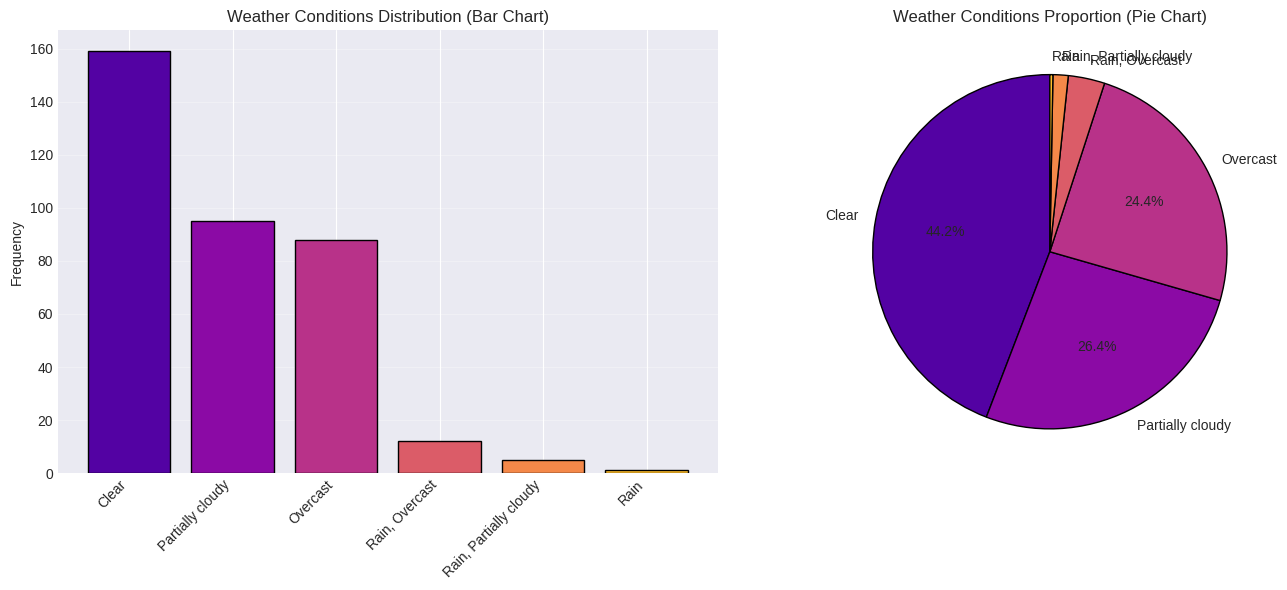

In [8]:
# Convert datetime to proper format
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek

# Analyze weather conditions distribution
print("="*80)
print("WEATHER CONDITIONS DISTRIBUTION")
print("="*80)
print("\nConditions Value Counts:")
print(df['conditions'].value_counts())

# Visualize conditions distribution
plt.figure(figsize=(14, 6)) # Increased figure size for better readability

condition_counts = df['conditions'].value_counts()
conditions = condition_counts.index
counts = condition_counts.values

# Define custom colors (using a different palette)
colors = sns.color_palette('plasma', len(conditions))

plt.subplot(1, 2, 1)
plt.bar(range(len(conditions)), counts, color=colors, edgecolor='black')
plt.xticks(range(len(conditions)), conditions, rotation=45, ha='right')
plt.ylabel('Frequency')
plt.title('Weather Conditions Distribution (Bar Chart)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
# Adjust autopct for less congestion, showing percentages only if greater than 5%
plt.pie(counts, labels=conditions, autopct=lambda p: '{:.1f}%'.format(p) if p > 5 else '', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title('Weather Conditions Proportion (Pie Chart)')

plt.tight_layout()
plt.show()

Creates or inspects meteorological features (pressure, wind, cloud cover, dew point, solar radiation, visibility).

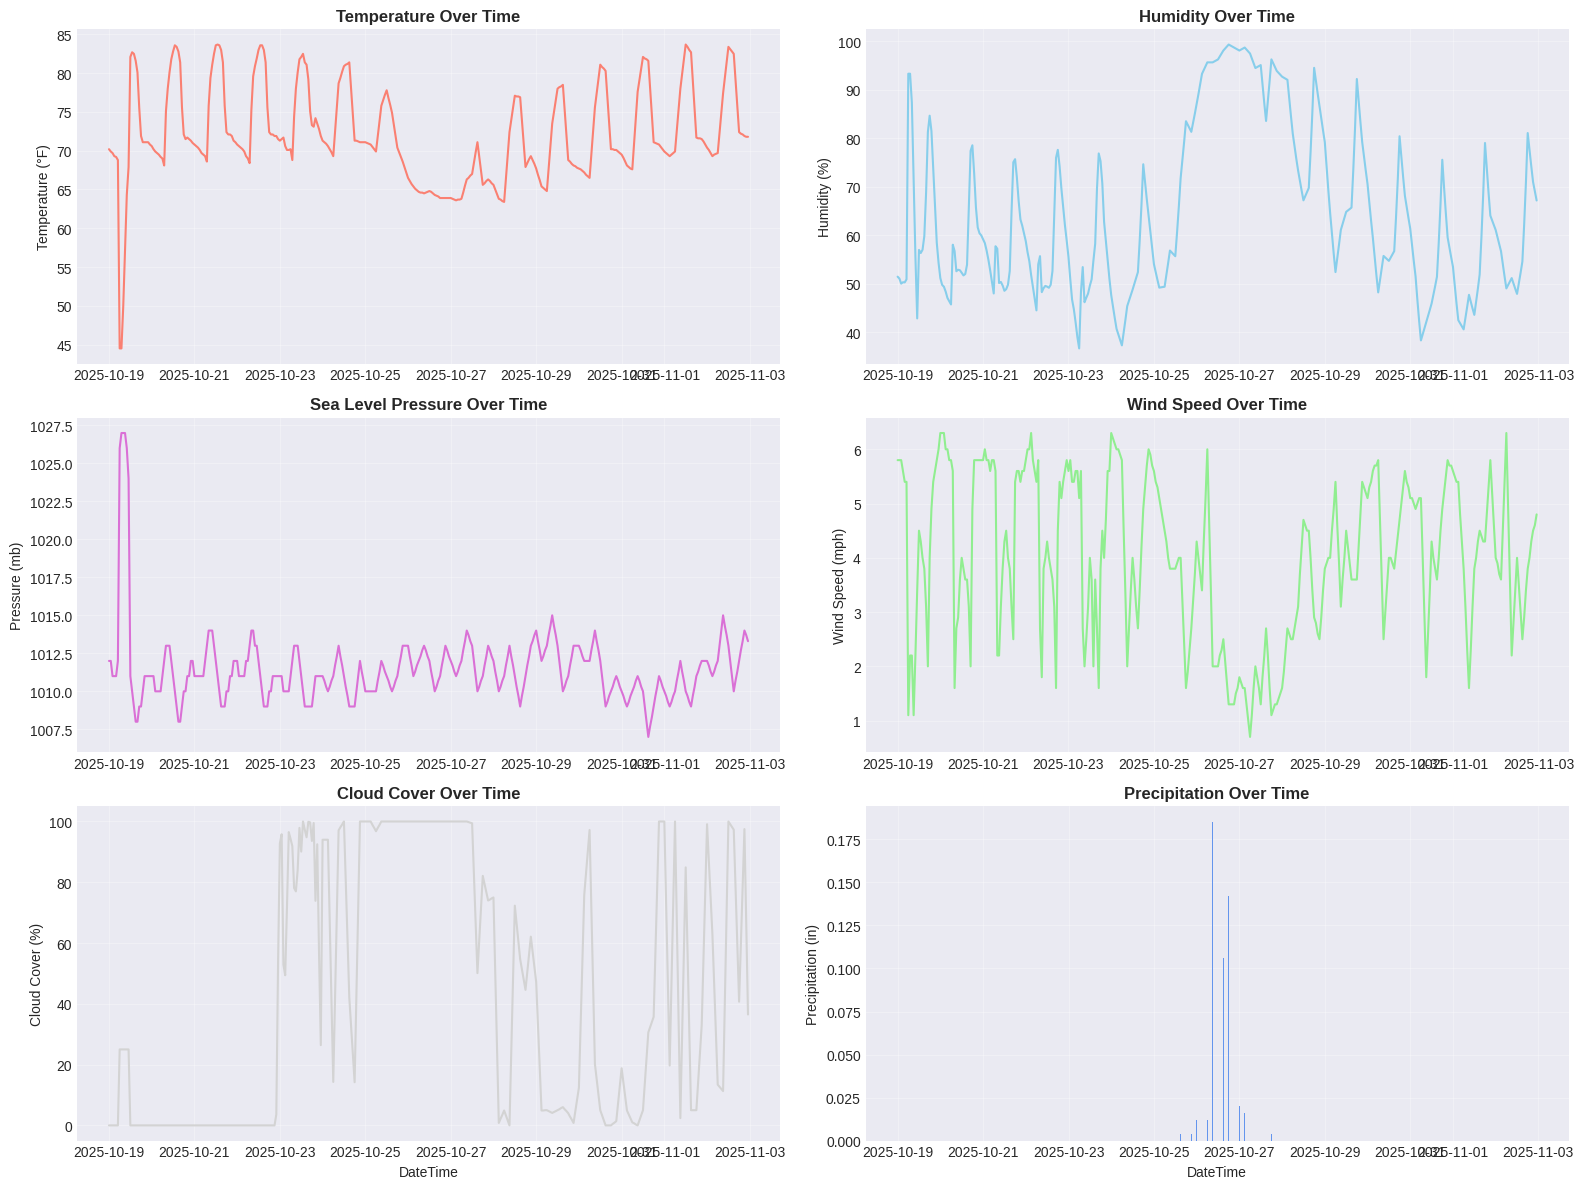

In [10]:
# Visualize key meteorological parameters over time
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Temperature
axes[0, 0].plot(df['datetime'], df['temp'], color='salmon', linewidth=1.5) # Changed color
axes[0, 0].set_title('Temperature Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Temperature (°F)')
axes[0, 0].grid(True, alpha=0.3)

# Humidity
axes[0, 1].plot(df['datetime'], df['humidity'], color='skyblue', linewidth=1.5) # Changed color
axes[0, 1].set_title('Humidity Over Time', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Humidity (%)')
axes[0, 1].grid(True, alpha=0.3)

# Sea Level Pressure
axes[1, 0].plot(df['datetime'], df['sealevelpressure'], color='orchid', linewidth=1.5) # Changed color
axes[1, 0].set_title('Sea Level Pressure Over Time', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Pressure (mb)')
axes[1, 0].grid(True, alpha=0.3)

# Wind Speed
axes[1, 1].plot(df['datetime'], df['windspeed'], color='lightgreen', linewidth=1.5) # Changed color
axes[1, 1].set_title('Wind Speed Over Time', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Wind Speed (mph)')
axes[1, 1].grid(True, alpha=0.3)

# Cloud Cover
axes[2, 0].plot(df['datetime'], df['cloudcover'], color='lightgray', linewidth=1.5) # Changed color
axes[2, 0].set_title('Cloud Cover Over Time', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Cloud Cover (%)')
axes[2, 0].set_xlabel('DateTime')
axes[2, 0].grid(True, alpha=0.3)

# Precipitation
axes[2, 1].bar(df['datetime'], df['precip'], color='cornflowerblue', width=0.02) # Changed color
axes[2, 1].set_title('Precipitation Over Time', fontsize=12, fontweight='bold')
axes[2, 1].set_ylabel('Precipitation (in)')
axes[2, 1].set_xlabel('DateTime')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Creates or inspects meteorological features (pressure, wind, cloud cover, dew point, solar radiation, visibility).

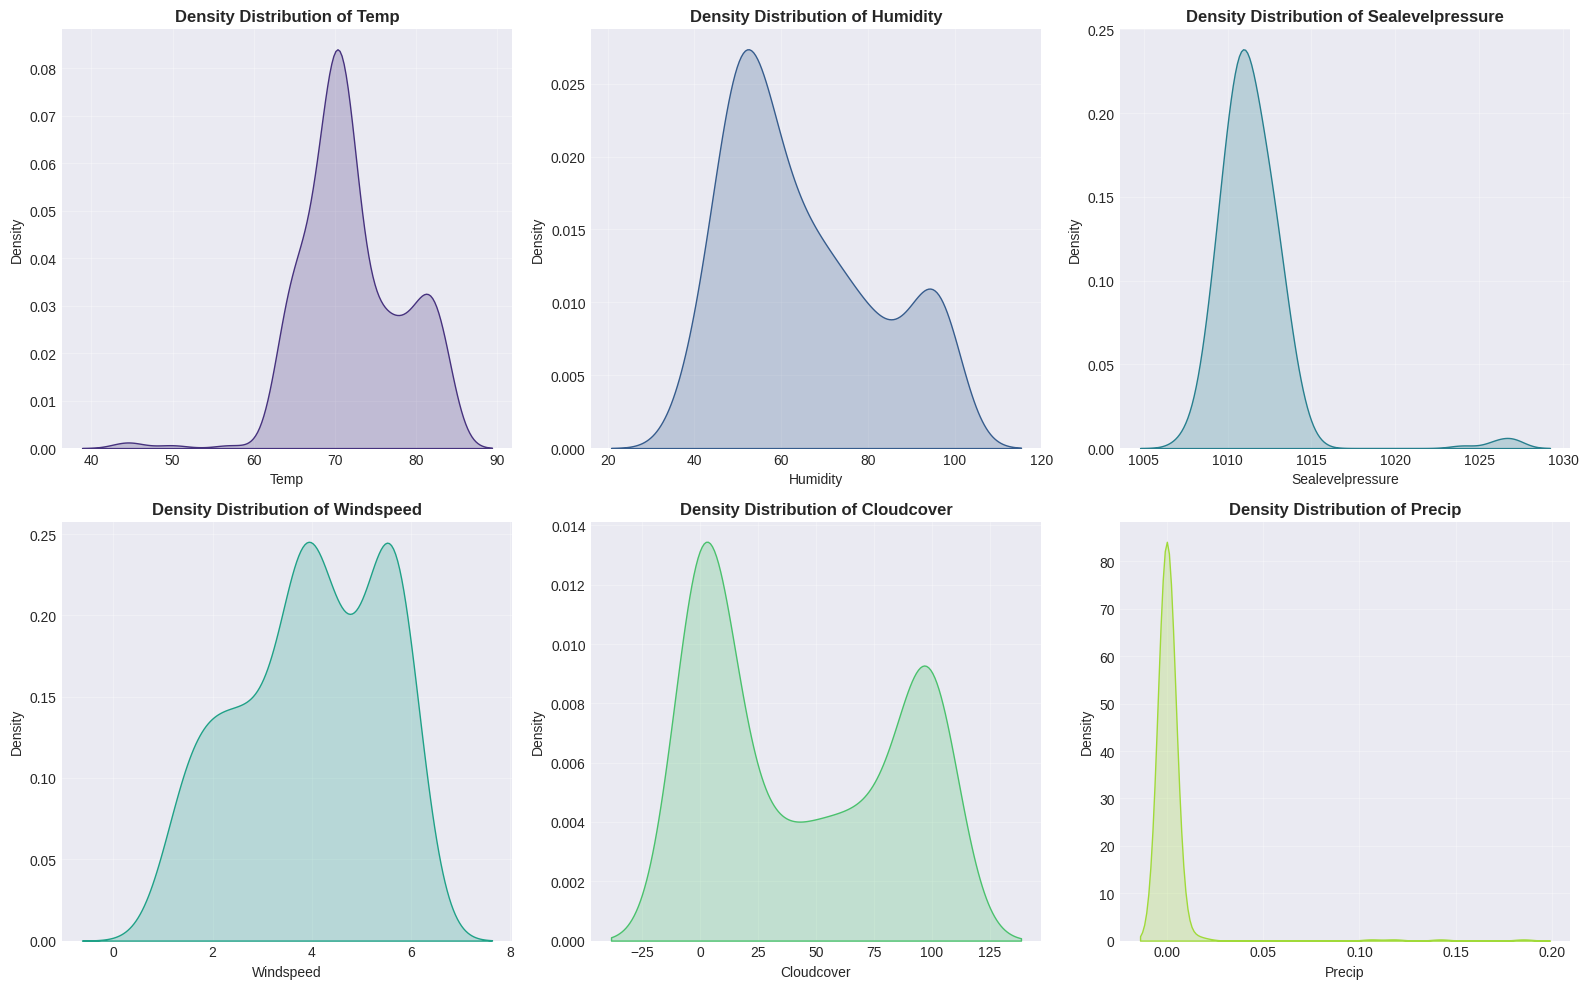

In [12]:
# Distribution plots for key features using density plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

features_to_plot = ['temp', 'humidity', 'sealevelpressure', 'windspeed', 'cloudcover', 'precip']
colors = sns.color_palette("viridis", len(features_to_plot)) # Using viridis palette

for idx, (feature, color) in enumerate(zip(features_to_plot, colors)):
    row = idx // 3
    col = idx % 3

    sns.kdeplot(data=df, x=feature, ax=axes[row, col], color=color, fill=True)
    axes[row, col].set_title(f'Density Distribution of {feature.capitalize()}', fontweight='bold')
    axes[row, col].set_xlabel(feature.capitalize())
    axes[row, col].set_ylabel('Density')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Creates or inspects meteorological features (pressure, wind, cloud cover, dew point, solar radiation, visibility).

CORRELATION ANALYSIS


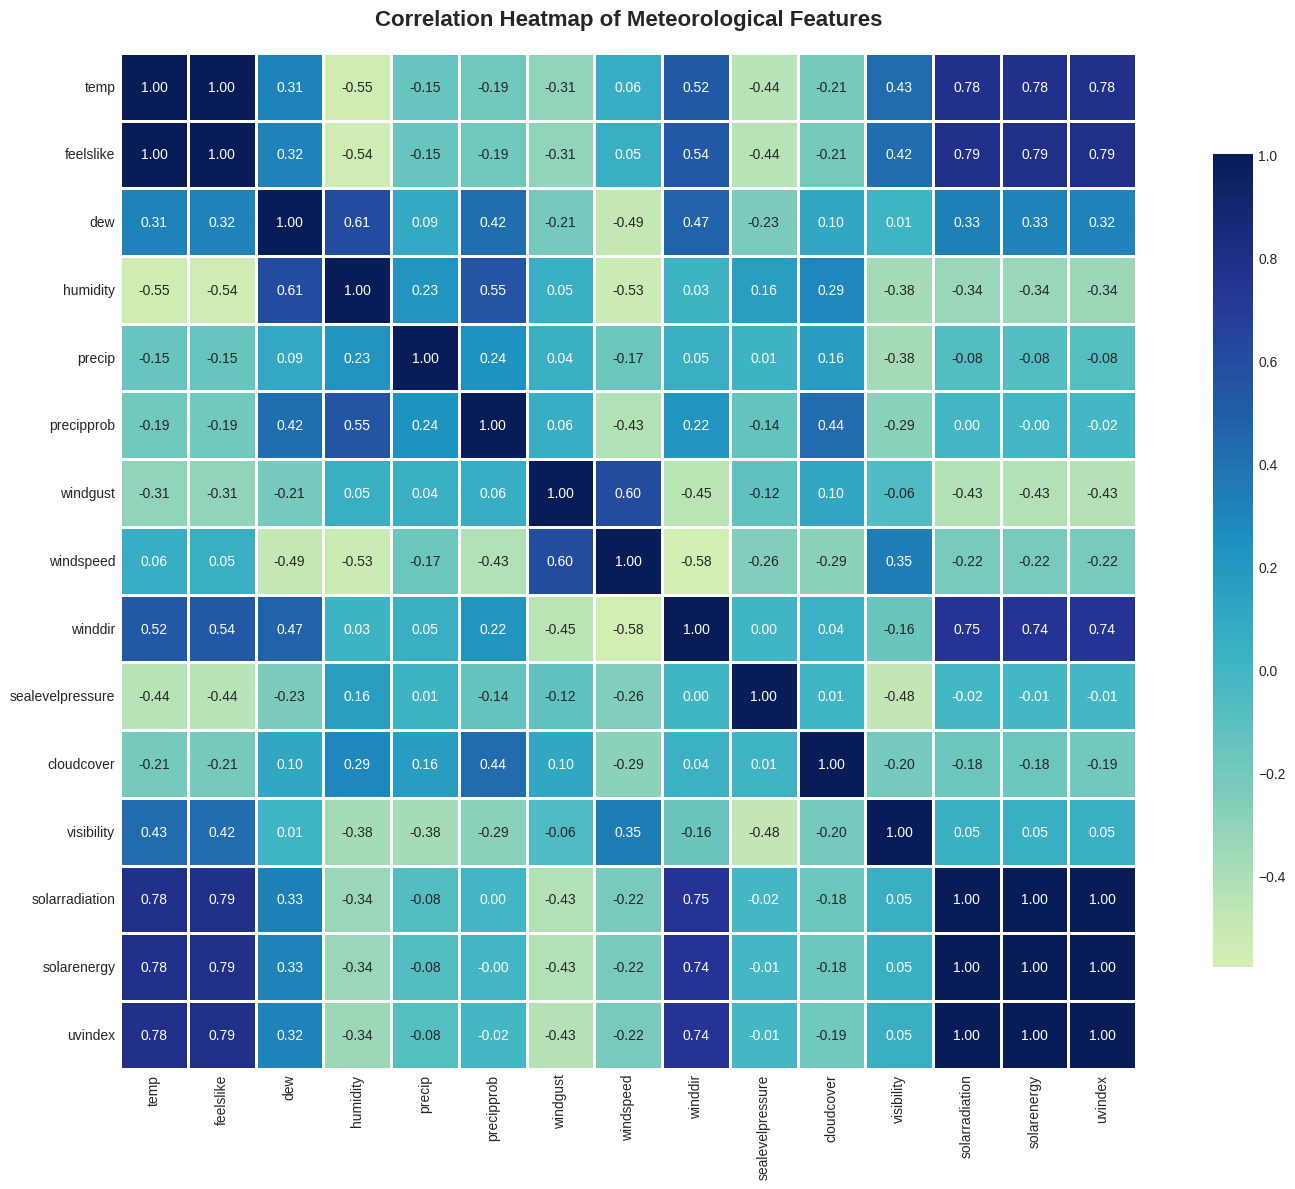


Highly Correlated Features (|correlation| > 0.7):


,Feature 1,Feature 2,Correlation
10,solarradiation,solarenergy,0.999708
0,temp,feelslike,0.997936
11,solarradiation,uvindex,0.996678
12,solarenergy,uvindex,0.996491
5,feelslike,solarenergy,0.792178
4,feelslike,solarradiation,0.791979
6,feelslike,uvindex,0.789244
2,temp,solarenergy,0.781985
1,temp,solarradiation,0.781650
3,temp,uvindex,0.778224


In [13]:
# Correlation Heatmap
print("="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Select numerical features for correlation
numerical_features = ['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
                     'windgust', 'windspeed', 'winddir', 'sealevelpressure',
                     'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex']

# Filter features that exist in the dataframe
available_features = [f for f in numerical_features if f in df.columns]
correlation_matrix = df[available_features].corr()

# Create heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='YlGnBu', # Changed colormap
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Meteorological Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print highly correlated features
print("\nHighly Correlated Features (|correlation| > 0.7):")
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr:
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', key=abs, ascending=False)
    display(high_corr_df)
else:
    print("No highly correlated feature pairs found.")

## 3. Feature engineering

Handles missing values and data cleaning (drop, fill, or interpolate missing entries).

Using df
Detected precipitation column: precip
Samples available: 355
Using features: ['winddir', 'cloudcover', 'solarradiation', 'visibility', 'sealevelpressure', 'temp', 'windspeed']


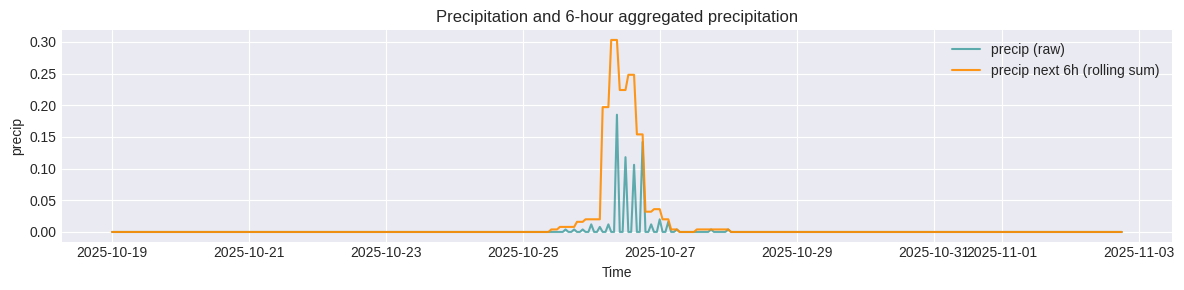

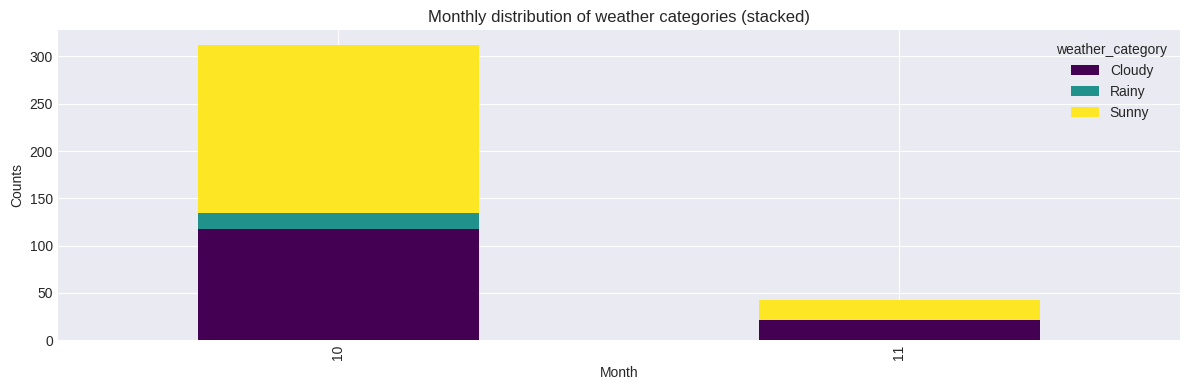

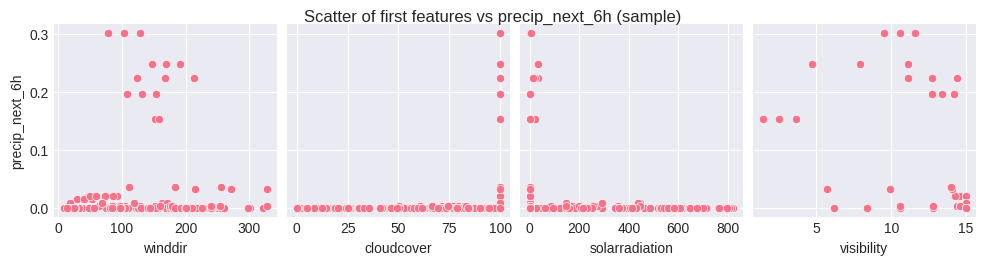

Skipping classification for fold 1: Only one class present in training data.
Classification CV summary:


,model,fold,accuracy,precision_macro,recall_macro,f1_macro
3,Persistence,3.5,1.000000,1.000000,1.000000,1.000000
4,RF_balanced,3.5,0.915254,0.822582,0.838694,0.828804
1,GB,3.5,0.877119,0.811944,0.840156,0.816967
2,LogReg_balanced,3.5,0.788136,0.720503,0.702795,0.654669
0,Climatology,3.5,0.440678,0.205508,0.416667,0.254581


Regression CV summary:


,model,fold,rmse,mae,r2
2,Persistence_reg,3.0,0.029014,0.011102,0.633240
3,RF_reg,3.0,0.034037,0.017560,0.113373
4,Ridge,3.0,0.036621,0.019948,0.181905
0,Climatology_reg,3.0,0.038341,0.019644,0.143578
1,GB_reg,3.0,0.039548,0.020253,-0.056940


Best classifier: Persistence


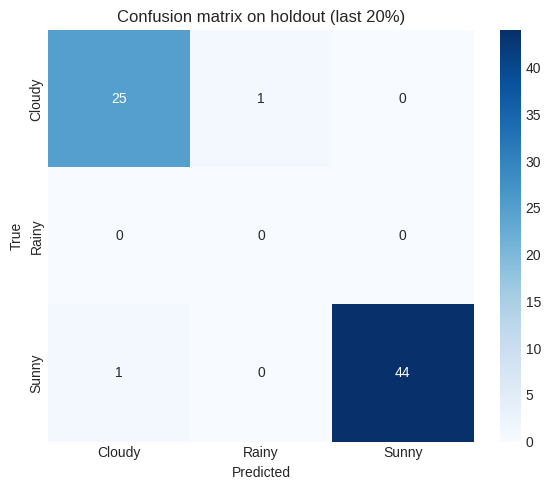

Integration cell finished. Next: copy results into report sections and discuss baselines vs models.


In [17]:
# === Integrated: Create regression targets, baselines, CV & evaluation ===
# This cell integrates into Feature Engineering / Model Evaluation sections.
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# --- auto-detection of key columns ---
# Use df_clean if available; fallback to df
try:
    df_use = df_clean.copy()
    print("Using df_clean")
except Exception:
    try:
        df_use = df.copy()
        print("Using df")
    except Exception as e:
        raise RuntimeError("No dataframe named df_clean or df found. Run previous cells to create it.")

# Detect precipitation column
precip_candidates = ['precip', 'precipitation', 'rain', 'rain_mm', 'precip_mm']
precip_col = None
for c in precip_candidates:
    if c in df_use.columns:
        precip_col = c
        break
if precip_col is None:
    # fallback: pick a numeric column with 'prec' or 'rain' in name
    for c in df_use.select_dtypes(include='number').columns:
        if 'prec' in c.lower() or 'rain' in c.lower():
            precip_col = c
            break
if precip_col is None:
    raise RuntimeError("Precipitation column not found. Expected one of: " + ", ".join(precip_candidates))

print("Detected precipitation column:", precip_col)

# Ensure datetime index
if 'datetime' in df_use.columns:
    df_use['datetime'] = pd.to_datetime(df_use['datetime'])
    df_use = df_use.sort_values('datetime').set_index('datetime')
else:
    try:
        df_use.index = pd.to_datetime(df_use.index)
        df_use = df_use.sort_index()
    except Exception as e:
        raise RuntimeError("No 'datetime' column or datetime-like index found; please convert the datetime column to pandas datetime.")

# --- Create regression targets: precip next 6h and 12h (assumes hourly data) ---
df_use['precip_next_6h'] = df_use[precip_col].rolling(window=6, min_periods=1).sum().shift(-5)
df_use['precip_next_12h'] = df_use[precip_col].rolling(window=12, min_periods=1).sum().shift(-11)
df_use['precip_any_next_6h'] = (df_use['precip_next_6h'] > 0).astype(int)

# --- Create / ensure weather_category exists ---
if 'weather_category' not in df_use.columns:
    # Try to create using simple rules if key columns present
    if 'cloudcover' in df_use.columns and precip_col in df_use.columns and 'winddir' in df_use.columns:
        def create_weather_category_simple(row):
            if row[precip_col] > 0.5 or row.get('precipprob',0) > 50:
                # if high precip -> Rainy or Stormy based on wind speed if available
                return 'Stormy' if (row.get('winddir',0) and row.get('winddir',0)>300) and row.get('winddir',0) else 'Rainy'
            if row.get('cloudcover',0) > 50:
                return 'Cloudy'
            return 'Sunny'
        df_use['weather_category'] = df_use.apply(create_weather_category_simple, axis=1)
        print("Created weather_category using simple rules (fallback).")
    else:
        raise RuntimeError("'weather_category' not found and not enough columns to create one automatically.")

# Drop rows where target is NaN (tail due to shift)
df_use = df_use.dropna(subset=['precip_next_6h']).copy()
print("Samples available:", len(df_use))

# --- Select features (recommended features) ---
possible_features = ['pressure','winddir','cloudcover','dewpoint','solarradiation','visibility','sealevelpressure','temp','windspd','windspeed']
features = [c for c in possible_features if c in df_use.columns]

# include existing lag columns if any from earlier cells
lag_cols = [c for c in df_use.columns if '_lag' in c]
features += lag_cols
features = list(dict.fromkeys(features))  # unique preserve order

if len(features) == 0:
    raise RuntimeError("No recommended features found. Available columns: " + ", ".join(df_use.columns[:20]))

X = df_use[features].fillna(method='ffill').fillna(method='bfill').fillna(0)
print("Using features:", features)

# Prepare targets
le = LabelEncoder()
y_class = df_use['weather_category'].astype(str)
y_class_enc = le.fit_transform(y_class)
class_names = list(le.classes_)

y_reg = df_use['precip_next_6h']

# --- Simple visualizations (replace older ones) ---
# 1) Time series of precipitation with 6h rolling sum
plt.figure(figsize=(12,3))
plt.plot(df_use.index, df_use[precip_col], alpha=0.6, label='precip (raw)', color='teal') # Changed color
plt.plot(df_use.index, df_use['precip_next_6h'], alpha=0.9, label='precip next 6h (rolling sum)', color='darkorange') # Changed color
plt.legend()
plt.title('Precipitation and 6-hour aggregated precipitation')
plt.xlabel('Time'); plt.ylabel(precip_col)
plt.tight_layout()
plt.show()

# 2) Weather category counts (stacked bar by month)
if 'weather_category' in df_use.columns:
    df_use['month'] = df_use.index.month
    cat_counts = df_use.groupby(['month','weather_category']).size().unstack(fill_value=0)
    cat_counts.plot(kind='bar', stacked=True, figsize=(12,4), cmap='viridis') # Changed colormap
    plt.title('Monthly distribution of weather categories (stacked)')
    plt.xlabel('Month'); plt.ylabel('Counts')
    plt.tight_layout()
    plt.show()

# 3) Pairwise scatter for key features vs precip_next_6h (sampled to speed)
sample = X.join(y_reg).sample(frac=min(1, 5000/max(1,len(X))), random_state=42)  # limit points
vars_plot = features[:4] if len(features)>=4 else features
sns.pairplot(sample, x_vars=vars_plot, y_vars='precip_next_6h', height=2.5, palette='plasma') # Changed palette
plt.suptitle('Scatter of first features vs precip_next_6h (sample)', y=1.02)
plt.show()

# --- Baselines: Persistence & Climatology ---
df_use['persistence_category'] = df_use['weather_category'].shift(0)
df_use['persistence_precip6'] = df_use[precip_col]

# --- TimeSeriesSplit CV (classification + regression) ---
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

def classification_metrics(y_true, y_pred):
    return {'accuracy': accuracy_score(y_true,y_pred),
            'precision_macro': precision_score(y_true,y_pred, average='macro', zero_division=0),
            'recall_macro': recall_score(y_true,y_pred, average='macro', zero_division=0),
            'f1_macro': f1_score(y_true,y_pred, average='macro', zero_division=0)}

def regression_metrics(y_true, y_pred):
    return {'rmse': np.sqrt(mean_squared_error(y_true,y_pred)),
            'mae': mean_absolute_error(y_true,y_pred),
            'r2': r2_score(y_true,y_pred)}

# Prepare classifiers & regressors
classifiers = {
    'RF_balanced': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'GB': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LogReg_balanced': LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial', solver='saga', random_state=42)
}

regressors = {
    'RF_reg': RandomForestRegressor(n_estimators=100, random_state=42),
    'GB_reg': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Ridge': Ridge()
}

# Run CV for classification
clf_results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y_class_enc[train_idx], y_class_enc[test_idx]
    scaler = StandardScaler().fit(X_tr)
    X_tr_s, X_te_s = scaler.transform(X_tr), scaler.transform(X_te)

    # --- Added check for number of classes in training fold ---
    if len(np.unique(y_tr)) < 2:
        print(f"Skipping classification for fold {fold}: Only one class present in training data.")
        # Add dummy results or skip adding results for this fold
        # For simplicity, we'll just skip adding results for this fold
        continue
    # --- End added check ---

    # baseline climatology
    from collections import Counter
    most_common = Counter(y_tr).most_common(1)[0][0]
    # persistence baseline (map to encoded labels if possible)
    try:
        persistence = df_use.iloc[test_idx]['persistence_category'].map(lambda x: le.transform([x])[0] if x in le.classes_ else most_common).values
    except Exception:
        persistence = np.full(len(y_te), most_common)

    for name, clf in classifiers.items():
        clf.fit(X_tr_s, y_tr)
        preds = clf.predict(X_te_s)
        clf_results.append({'model':name,'fold':fold,**classification_metrics(y_te,preds)})
    clf_results.append({'model':'Climatology','fold':fold,**classification_metrics(y_te, np.full(len(y_te), most_common))})
    clf_results.append({'model':'Persistence','fold':fold,**classification_metrics(y_te, persistence)})

clf_df = pd.DataFrame(clf_results)
if not clf_df.empty:
    clf_summary = clf_df.groupby('model').mean().reset_index().sort_values('f1_macro', ascending=False)
    print("Classification CV summary:")
    display(clf_summary)
else:
    print("Classification CV could not be completed due to insufficient classes in all folds.")
    clf_summary = pd.DataFrame() # Create empty dataframe to avoid errors later

# Run CV for regression (precip_next_6h)
reg_results = []
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y_reg.iloc[train_idx], y_reg.iloc[test_idx]
    scaler = StandardScaler().fit(X_tr)
    X_tr_s, X_te_s = scaler.transform(X_tr), scaler.transform(X_te)
    persistence_pred = df_use.iloc[test_idx]['persistence_precip6'].values
    for name, reg in regressors.items():
        reg.fit(X_tr_s, y_tr)
        preds = reg.predict(X_te_s)
        reg_results.append({'model':name,'fold':fold,**regression_metrics(y_te,preds)})
    reg_results.append({'model':'Persistence_reg','fold':fold,**regression_metrics(y_te,persistence_pred)})
    reg_results.append({'model':'Climatology_reg','fold':fold,**regression_metrics(y_te, np.full(len(y_te), y_tr.mean()))})

reg_df = pd.DataFrame(reg_results)
reg_summary = reg_df.groupby('model').mean().reset_index().sort_values('rmse')
print("Regression CV summary:")
display(reg_summary)

# --- Confusion matrix on holdout (last 20%) for best classifier ---
if not clf_summary.empty:
    best_clf = clf_summary.sort_values('f1_macro', ascending=False)['model'].iloc[0]
    print("Best classifier:", best_clf)
    split_idx = int(len(X)*0.8)
    X_tr, X_te = X.iloc[:split_idx], X.iloc[split_idx:]
    y_tr, y_te = y_class_enc[:split_idx], y_class_enc[split_idx:]

    # --- Added check for number of classes in holdout training set ---
    if len(np.unique(y_tr)) < 2:
         print("Skipping confusion matrix: Only one class present in holdout training data.")
    else:
        scaler = StandardScaler().fit(X_tr)
        X_tr_s, X_te_s = scaler.transform(X_tr), scaler.transform(X_te)
        if 'RF' in best_clf:
            model_final = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
        elif 'GB' in best_clf:
            model_final = GradientBoostingClassifier(n_estimators=200, random_state=42)
        else:
            model_final = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial', solver='saga', random_state=42)
        model_final.fit(X_tr_s, y_tr)
        pred_hold = model_final.predict(X_te_s)
        cm = confusion_matrix(y_te, pred_hold)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
        plt.title('Confusion matrix on holdout (last 20%)')
        plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout()
        plt.show()
else:
    print("Skipping confusion matrix: Classification CV did not produce results.")

# --- Save small summaries into notebook namespace for later reporting ---
cv_class_summary = clf_summary
cv_reg_summary = reg_summary
cv_class_df = clf_df
cv_reg_df = reg_df

print("Integration cell finished. Next: copy results into report sections and discuss baselines vs models.")

Creates or inspects meteorological features (pressure, wind, cloud cover, dew point, solar radiation, visibility).

WEATHER CATEGORY DISTRIBUTION

Category Counts:
weather_category
Sunny     201
Cloudy    143
Rainy      16
Name: count, dtype: int64

Category Percentages:
weather_category
Sunny     55.833333
Cloudy    39.722222
Rainy      4.444444
Name: proportion, dtype: float64


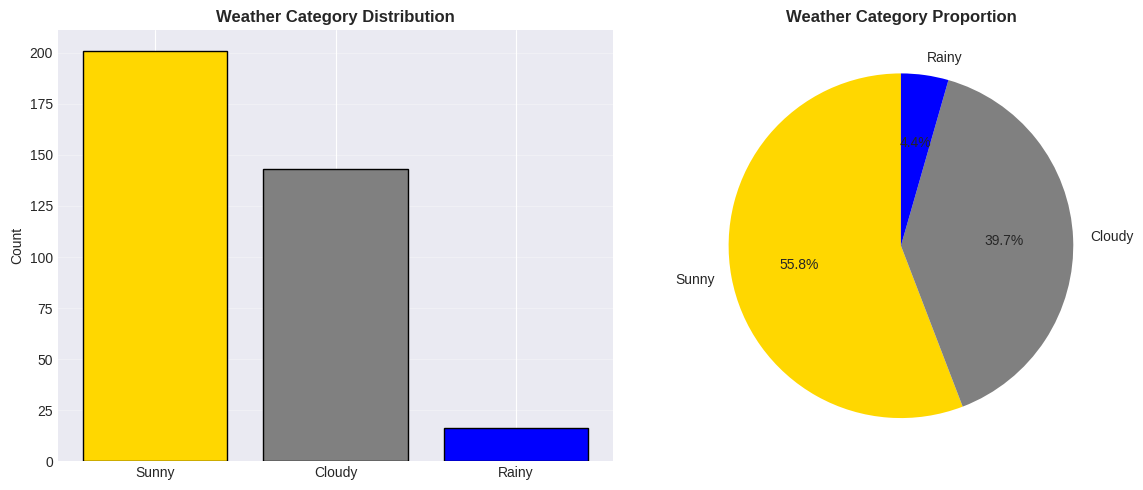

In [18]:
# Create target variable: Weather Category
# Based on cloud cover, precipitation, and conditions
def create_weather_category(row):
    """
    Create weather categories based on meteorological rules:
    - Stormy: High precipitation + high wind OR precipprob > 70
    - Rainy: Precipitation > 0 and cloudcover > 50
    - Cloudy: cloudcover > 50 and no precipitation
    - Sunny: cloudcover <= 50 and no precipitation
    """
    if pd.isna(row['cloudcover']) or pd.isna(row['precip']):
        return 'Unknown'

    # Check for storm conditions
    if (row['precip'] > 0.1 and row['windspeed'] > 15) or row['precipprob'] > 70:
        return 'Stormy'

    # Check for rain
    elif row['precip'] > 0 and row['cloudcover'] > 50:
        return 'Rainy'

    # Check for cloudy
    elif row['cloudcover'] > 50:
        return 'Cloudy'

    # Otherwise sunny/clear
    else:
        return 'Sunny'

# Apply the function
df['weather_category'] = df.apply(create_weather_category, axis=1)

print("="*80)
print("WEATHER CATEGORY DISTRIBUTION")
print("="*80)
print("\nCategory Counts:")
print(df['weather_category'].value_counts())
print("\nCategory Percentages:")
print(df['weather_category'].value_counts(normalize=True) * 100)

# Visualize
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
category_counts = df['weather_category'].value_counts()
colors_map = {'Sunny': 'gold', 'Cloudy': 'gray', 'Rainy': 'blue', 'Stormy': 'darkred'}
colors = [colors_map.get(cat, 'lightgray') for cat in category_counts.index]
plt.bar(range(len(category_counts)), category_counts.values, color=colors, edgecolor='black')
plt.xticks(range(len(category_counts)), category_counts.index)
plt.ylabel('Count')
plt.title('Weather Category Distribution', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Weather Category Proportion', fontweight='bold')

plt.tight_layout()
plt.show()

Performs data processing or modeling steps. (Add a custom explanation here if you want a more specific description.)

In [19]:
# Create temporal features
print("\n" + "="*80)
print("CREATING TEMPORAL FEATURES")
print("="*80)

# Hour-based features
df['is_night'] = ((df['hour'] >= 20) | (df['hour'] <= 6)).astype(int)
df['is_morning'] = ((df['hour'] >= 6) & (df['hour'] < 12)).astype(int)
df['is_afternoon'] = ((df['hour'] >= 12) & (df['hour'] < 18)).astype(int)
df['is_evening'] = ((df['hour'] >= 18) & (df['hour'] < 20)).astype(int)

# Cyclical encoding for hour (sine and cosine transformation)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Day of week cyclical encoding
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

print("✓ Temporal features created:")
print("  - is_night, is_morning, is_afternoon, is_evening")
print("  - hour_sin, hour_cos (cyclical encoding)")
print("  - dayofweek_sin, dayofweek_cos (cyclical encoding)")


CREATING TEMPORAL FEATURES
✓ Temporal features created:
  - is_night, is_morning, is_afternoon, is_evening
  - hour_sin, hour_cos (cyclical encoding)
  - dayofweek_sin, dayofweek_cos (cyclical encoding)


Performs time-series feature engineering (resampling, shifts, rolling statistics, or datetime feature extraction).

In [20]:
# Create lag features (previous hours' data)
print("\n" + "="*80)
print("CREATING LAG FEATURES")
print("="*80)

lag_features = ['temp', 'humidity', 'sealevelpressure', 'windspeed', 'cloudcover']
lag_hours = [1, 3, 6]  # 1, 3, and 6 hours ago

for feature in lag_features:
    for lag in lag_hours:
        df[f'{feature}_lag_{lag}h'] = df[feature].shift(lag)

print(f"✓ Created lag features for: {', '.join(lag_features)}")
print(f"  Lags: {lag_hours} hours")

# Create rolling statistics (moving averages and std)
print("\n" + "="*80)
print("CREATING ROLLING STATISTICS")
print("="*80)

rolling_windows = [3, 6]  # 3-hour and 6-hour windows

for feature in lag_features:
    for window in rolling_windows:
        df[f'{feature}_rolling_mean_{window}h'] = df[feature].rolling(window=window, min_periods=1).mean()
        df[f'{feature}_rolling_std_{window}h'] = df[feature].rolling(window=window, min_periods=1).std()

print(f"✓ Created rolling statistics for: {', '.join(lag_features)}")
print(f"  Windows: {rolling_windows} hours")
print(f"  Stats: mean, std")

# Rate of change features
print("\n" + "="*80)
print("CREATING RATE OF CHANGE FEATURES")
print("="*80)

for feature in ['temp', 'sealevelpressure', 'humidity']:
    df[f'{feature}_change_1h'] = df[feature].diff(1)
    df[f'{feature}_change_3h'] = df[feature].diff(3)

print("✓ Created rate of change features for temperature, pressure, and humidity")

print(f"\n✓ Total features after engineering: {len(df.columns)}")


CREATING LAG FEATURES
✓ Created lag features for: temp, humidity, sealevelpressure, windspeed, cloudcover
  Lags: [1, 3, 6] hours

CREATING ROLLING STATISTICS
✓ Created rolling statistics for: temp, humidity, sealevelpressure, windspeed, cloudcover
  Windows: [3, 6] hours
  Stats: mean, std

CREATING RATE OF CHANGE FEATURES
✓ Created rate of change features for temperature, pressure, and humidity

✓ Total features after engineering: 77


## 4. Data preprocessing

Handles missing values and data cleaning (drop, fill, or interpolate missing entries).

In [21]:
# Remove rows with Unknown category and handle missing values from lag features
print("="*80)
print("DATA CLEANING")
print("="*80)

print(f"\nOriginal dataset size: {len(df)} rows")

# Remove Unknown categories
df = df[df['weather_category'] != 'Unknown'].copy()
print(f"After removing 'Unknown' categories: {len(df)} rows")

# Drop rows with missing values (from lag features)
df_clean = df.dropna().copy()
print(f"After removing rows with NaN values: {len(df_clean)} rows")

print(f"\n✓ Clean dataset ready with {len(df_clean)} samples")

DATA CLEANING

Original dataset size: 360 rows
After removing 'Unknown' categories: 360 rows
After removing rows with NaN values: 0 rows

✓ Clean dataset ready with 0 samples


In [22]:
# Improved data cleaning approach
print("="*80)
print("IMPROVED DATA CLEANING & PREPARATION")
print("="*80)

# First, let's see the current state
print(f"\nOriginal dataset size: {len(df)} rows")
print(f"Missing values per column:")
missing_info = df.isnull().sum()
lag_features = [col for col in df.columns if 'lag_' in col or 'rolling_' in col or 'change_' in col]
print(f"Lag/Rolling features created: {len(lag_features)}")
print(f"Missing values in lag features: {df[lag_features].isnull().sum().max()}")

# Remove rows with Unknown categories (though we don't have any)
df_work = df[df['weather_category'] != 'Unknown'].copy()
print(f"After removing 'Unknown' categories: {len(df_work)} rows")

# For lag features, we'll only drop the first few rows where we can't compute lags
# Instead of dropping all NaN, we'll drop only the initial rows that can't have lag features
max_lag = 6  # Maximum lag is 6 hours
df_clean = df_work.iloc[max_lag:].copy()  # Drop first 6 rows

print(f"After removing initial {max_lag} rows (for lag features): {len(df_clean)} rows")

# Now fill any remaining NaN values with forward fill
df_clean = df_clean.fillna(method='ffill')
print(f"After forward fill: {len(df_clean)} rows")

# Check final state
print(f"\n✓ Clean dataset ready with {len(df_clean)} samples")
print(f"Weather category distribution:")
print(df_clean['weather_category'].value_counts())

IMPROVED DATA CLEANING & PREPARATION

Original dataset size: 360 rows
Missing values per column:
Lag/Rolling features created: 41
Missing values in lag features: 6
After removing 'Unknown' categories: 360 rows
After removing initial 6 rows (for lag features): 354 rows
After forward fill: 354 rows

✓ Clean dataset ready with 354 samples
Weather category distribution:
weather_category
Sunny     195
Cloudy    143
Rainy      16
Name: count, dtype: int64


Creates or inspects meteorological features (pressure, wind, cloud cover, dew point, solar radiation, visibility).

In [23]:
# Select features for modeling
print("\n" + "="*80)
print("FEATURE SELECTION AND CREATION")
print("="*80)

# Define required features
required_features = [
    'sealevelpressure',  # Used to calculate atmospheric pressure
    'winddir',
    'cloudcover',
    'dew',
    'solarradiation',
    'visibility',
    'datetime' # Keep datetime temporarily for calculating altitude if needed
]

# Filter features that exist in the dataframe
feature_columns = [f for f in required_features if f in df_clean.columns]

# Estimate Atmospheric Pressure (using a simplified barometric formula)
# Assuming a constant altitude for Bhutan data for simplicity.
# A more accurate approach would require altitude for each data point if available.
# Let's assume a representative altitude for Bhutan, e.g., Thimphu is around 2334 meters.
# P = P0 * (1 - 2.25577 * 10^-5 * h)^5.25588
# P0 = sealevelpressure (in hPa)
# h = altitude in meters
altitude_meters = 2334 # Representative altitude for Thimphu, Bhutan

df_clean['Atmospheric Pressure (hPa)'] = df_clean['sealevelpressure'] * (1 - 2.25577e-5 * altitude_meters)**5.25588

# Define final set of features to keep
final_features_to_keep = [
    'Atmospheric Pressure (hPa)',
    'winddir',
    'cloudcover',
    'dew',
    'solarradiation',
    'visibility',
    'sealevelpressure',
    'weather_category' # Keep the target variable
]

# Keep only the final required features
df_processed = df_clean[final_features_to_keep].copy()

print("\nOriginal DataFrame head before feature selection:")
display(df_clean.head())

print("\nProcessed DataFrame head after feature selection and creation:")
display(df_processed.head())
print(f"\nTotal features selected and created: {len(df_processed.columns) - 1} (excluding target)") # Subtract 1 for the target column

# Prepare X and y from the processed DataFrame
X = df_processed.drop('weather_category', axis=1).copy()
y = df_processed['weather_category'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())
print("The length of the data is:")
print(len(y))


FEATURE SELECTION AND CREATION

Original DataFrame head before feature selection:


,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations,hour,day,dayofweek,weather_category,is_night,is_morning,is_afternoon,is_evening,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,temp_lag_1h,temp_lag_3h,temp_lag_6h,humidity_lag_1h,humidity_lag_3h,humidity_lag_6h,sealevelpressure_lag_1h,sealevelpressure_lag_3h,sealevelpressure_lag_6h,windspeed_lag_1h,windspeed_lag_3h,windspeed_lag_6h,cloudcover_lag_1h,cloudcover_lag_3h,cloudcover_lag_6h,temp_rolling_mean_3h,temp_rolling_std_3h,temp_rolling_mean_6h,temp_rolling_std_6h,humidity_rolling_mean_3h,humidity_rolling_std_3h,humidity_rolling_mean_6h,humidity_rolling_std_6h,sealevelpressure_rolling_mean_3h,sealevelpressure_rolling_std_3h,sealevelpressure_rolling_mean_6h,sealevelpressure_rolling_std_6h,windspeed_rolling_mean_3h,windspeed_rolling_std_3h,windspeed_rolling_mean_6h,windspeed_rolling_std_6h,cloudcover_rolling_mean_3h,cloudcover_rolling_std_3h,cloudcover_rolling_mean_6h,cloudcover_rolling_std_6h,temp_change_1h,temp_change_3h,sealevelpressure_change_1h,sealevelpressure_change_3h,humidity_change_1h,humidity_change_3h,Atmospheric Pressure (hPa)
6,"26.8544,89.3890",2025-10-19 06:00:00,44.5,44.5,42.7,93.35,0.0,0.0,NaN,0,0,4.0,1.1,23.8,1026.0,25.0,6.2,0.0,0.0,0,10,Partially cloudy,partly-cloudy-night,VQPR,6,19,6,Sunny,1,1,0,0,1.000000,6.123234e-17,-0.781831,0.62349,68.8,69.3,70.2,50.93,50.33,51.48,1012.0,1011.0,1012.0,5.4,5.6,5.8,0.0,0.0,0.0,60.833333,14.146495,65.233333,10.164579,64.863333,24.672125,57.676667,17.480822,1016.333333,8.386497,1013.833333,5.980524,3.966667,2.482606,4.850000,1.845806,8.333333,14.433757,4.166667,10.206207,-24.3,-24.8,14.0,15.0,42.42,43.02,772.129144
7,"26.8544,89.3890",2025-10-19 07:00:00,44.5,44.5,42.7,93.35,0.0,0.0,NaN,0,0,4.0,2.2,140.0,1027.0,25.0,6.2,50.0,0.2,1,10,Partially cloudy,partly-cloudy-day,VQPR,7,19,6,Sunny,0,1,0,0,0.965926,-2.588190e-01,-0.781831,0.62349,44.5,69.2,69.9,93.35,50.31,51.09,1026.0,1011.0,1012.0,1.1,5.4,5.8,25.0,0.0,0.0,52.600000,14.029612,61.000000,12.784053,79.210000,24.491198,64.720000,22.178580,1021.666667,8.386497,1016.333333,7.890923,2.900000,2.233831,4.250000,2.049146,16.666667,14.433757,8.333333,12.909944,0.0,-24.7,1.0,16.0,0.00,43.04,772.881707
8,"26.8544,89.3890",2025-10-19 08:00:00,49.9,49.9,46.3,87.38,0.0,0.0,NaN,0,0,1.3,2.2,27.7,1027.0,25.0,6.2,252.0,0.9,3,10,Partially cloudy,partly-cloudy-day,VQPR,8,19,6,Sunny,0,1,0,0,0.866025,-5.000000e-01,-0.781831,0.62349,44.5,68.8,69.7,93.35,50.93,50.05,1027.0,1012.0,1011.0,2.2,5.4,5.8,25.0,0.0,0.0,46.300000,3.117691,57.700000,12.643892,91.360000,3.446781,70.941667,22.474247,1026.666667,0.577350,1019.000000,8.414274,1.833333,0.635085,3.650000,2.031502,25.000000,0.000000,12.500000,13.693064,5.4,-18.9,0.0,15.0,-5.97,36.45,772.881707
9,"26.8544,89.3890",2025-10-19 09:00:00,57.1,57.1,48.1,71.84,0.0,0.0,NaN,0,0,2.0,1.1,197.8,1027.0,25.0,6.2,463.0,1.7,5,3,Partially cloudy,partly-cloudy-day,VQPR,9,19,6,Sunny,0,1,0,0,0.707107,-7.071068e-01,-0.781831,0.62349,49.9,44.5,69.3,87.38,93.35,50.33,1027.0,1026.0,1011.0,2.2,1.1,5.6,25.0,25.0,0.0,50.500000,6.321392,55.666667,11.316654,84.190000,11.104148,74.526667,20.121191,1027.000000,0.000000,1021.666667,7.890923,1.833333,0.635085,2.900000,1.997999,25.000000,0.000000,16.666667,12.909944,7.2,12.6,0.0,1.0,-15.54,-21.51,772.881707
10,"26.8544,89.3890",2025-10-19 10:00:00,64.3,64.3,48.1,55.64,0.0,0.0,NaN,0,0,2.2,2.2,198.6,1026.0,25.0,6.2,639.0,2.3,6,3,Partially cloudy,partly-cloudy-day,VQPR,10,19,6,Sunny,0,1,0,0,0.500000,-8.660254e-01,-0.781831,0.62349,57.1,44.5,69.2,71.84,93.35,50.31,1027.0,1027.0,1011.0,1.1,2.2,5.4,25.0,25.0,0.0,57.100000,7.200000,54.850000,10.273412,71.620000,15.871144,75.415000,18.920022,1026.666667,0.577350,1024.166667,5.980524,1.833333,0.635085,2.366667,1.580717,25.000000,0.000000,20.833333,10.206207,7.2,19.8,-1.0,-1.0,-16.20,-37.71,772.129144



Processed DataFrame head after feature selection and creation:


,Atmospheric Pressure (hPa),winddir,cloudcover,dew,solarradiation,visibility,sealevelpressure,weather_category
6,772.129144,23.8,25.0,42.7,0.0,6.2,1026.0,Sunny
7,772.881707,140.0,25.0,42.7,50.0,6.2,1027.0,Sunny
8,772.881707,27.7,25.0,46.3,252.0,6.2,1027.0,Sunny
9,772.881707,197.8,25.0,48.1,463.0,6.2,1027.0,Sunny
10,772.129144,198.6,25.0,48.1,639.0,6.2,1026.0,Sunny



Total features selected and created: 7 (excluding target)

Feature matrix shape: (354, 7)
Target vector shape: (354,)

Target distribution:
weather_category
Sunny     195
Cloudy    143
Rainy      16
Name: count, dtype: int64
The length of the data is:
354


Creates the target variable (weather category) using engineered rules from meteorological parameters.

In [24]:
# Encode target variable
print("\n" + "="*80)
print("ENCODING TARGET VARIABLE")
print("="*80)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label encoding mapping:")
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {idx}")

# Store for later use
class_names = label_encoder.classes_


ENCODING TARGET VARIABLE
Label encoding mapping:
  Cloudy: 0
  Rainy: 1
  Sunny: 2


Performs data processing or modeling steps. (Add a custom explanation here if you want a more specific description.)

In [25]:
# Temporal train-test split (IMPORTANT for time series)
print("\n" + "="*80)
print("TRAIN-TEST SPLIT (TEMPORAL)")
print("="*80)

# Use 80% for training, 20% for testing (chronological split)
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx].copy()
X_test = X.iloc[split_idx:].copy()
y_train = y_encoded[:split_idx].copy()
y_test = y_encoded[split_idx:].copy()

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print("\nTraining set class distribution:")
for idx, class_name in enumerate(class_names):
    count = np.sum(y_train == idx)
    print(f"  {class_name}: {count} ({count/len(y_train)*100:.1f}%)")

print("\nTest set class distribution:")
for idx, class_name in enumerate(class_names):
    count = np.sum(y_test == idx)
    print(f"  {class_name}: {count} ({count/len(y_test)*100:.1f}%)")


TRAIN-TEST SPLIT (TEMPORAL)
Training set: 283 samples (79.9%)
Test set: 71 samples (20.1%)

Training set class distribution:
  Cloudy: 113 (39.9%)
  Rainy: 16 (5.7%)
  Sunny: 154 (54.4%)

Test set class distribution:
  Cloudy: 30 (42.3%)
  Rainy: 0 (0.0%)
  Sunny: 41 (57.7%)


Performs data processing or modeling steps. (Add a custom explanation here if you want a more specific description.)

In [26]:
# Feature scaling/normalization
print("\n" + "="*80)
print("FEATURE NORMALIZATION")
print("="*80)

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only (prevent data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features normalized using StandardScaler")
print(f"  Mean: {X_train_scaled.mean():.6f}")
print(f"  Std: {X_train_scaled.std():.6f}")
print("\n✓ Data preprocessing completed successfully!")


FEATURE NORMALIZATION
✓ Features normalized using StandardScaler
  Mean: 0.000000
  Std: 1.000000

✓ Data preprocessing completed successfully!


## 5. Model Training

Performs data processing or modeling steps. (Add a custom explanation here if you want a more specific description.)

In [27]:
# Initialize dictionary to store model results
model_results = {}

print("="*80)
print("MODEL TRAINING - MULTIPLE APPROACHES")
print("="*80)

MODEL TRAINING - MULTIPLE APPROACHES


### 5.1 Random Forest Classifier

Imports required Python libraries and modules used in this notebook.

In [29]:
import time

print("\n" + "="*80)
print("TRAINING: RANDOM FOREST CLASSIFIER")
print("="*80)

# Initialize model with parameters
rf_model = RandomForestClassifier(
    n_estimators=100,          # Number of trees
    max_depth=15,              # Maximum depth of trees
    min_samples_split=5,       # Minimum samples to split a node
    min_samples_leaf=2,        # Minimum samples in leaf node
    random_state=42,           # For reproducibility
    n_jobs=-1,                 # Use all processors
    verbose=1                  # Show progress
)

# Train the model
print("\nTraining Random Forest...")
start_time = time.time()
rf_model.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)

# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
rf_recall = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

# Store results
model_results['Random Forest'] = {
    'model': rf_model,
    'predictions': y_pred_rf,
    'predictions_proba': y_pred_proba_rf,
    'accuracy': rf_accuracy,
    'precision': rf_precision,
    'recall': rf_recall,
    'f1_score': rf_f1,
    'training_time': training_time
}

print(f"\n✓ Training completed in {training_time:.2f} seconds")
print(f"\n RANDOM FOREST RESULTS:")
print(f"   Accuracy:  {rf_accuracy:.4f}")
print(f"   Precision: {rf_precision:.4f}")
print(f"   Recall:    {rf_recall:.4f}")
print(f"   F1-Score:  {rf_f1:.4f}")


TRAINING: RANDOM FOREST CLASSIFIER

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s



✓ Training completed in 0.33 seconds

 RANDOM FOREST RESULTS:
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


### 5.2 Gradient Boosting Classifier

Defines and trains a machine learning model on the training data; evaluates predictions on validation/test sets.

In [32]:
print("\n" + "="*80)
print("TRAINING: GRADIENT BOOSTING CLASSIFIER")
print("="*80)

# Initialize model with parameters
gb_model = GradientBoostingClassifier(
    n_estimators=100,          # Number of boosting stages
    learning_rate=0.1,         # Learning rate
    max_depth=5,               # Maximum depth of trees
    min_samples_split=5,       # Minimum samples to split
    min_samples_leaf=2,        # Minimum samples in leaf
    subsample=0.8,             # Fraction of samples for fitting
    random_state=42,           # For reproducibility
    verbose=1                  # Show progress
)

# Train the model
print("\nTraining Gradient Boosting...")
start_time = time.time()
gb_model.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)

# Calculate metrics
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_precision = precision_score(y_test, y_pred_gb, average='weighted', zero_division=0)
gb_recall = recall_score(y_test, y_pred_gb, average='weighted', zero_division=0)
gb_f1 = f1_score(y_test, y_pred_gb, average='weighted', zero_division=0)

# Store results
model_results['Gradient Boosting'] = {
    'model': gb_model,
    'predictions': y_pred_gb,
    'predictions_proba': y_pred_proba_gb,
    'accuracy': gb_accuracy,
    'precision': gb_precision,
    'recall': gb_recall,
    'f1_score': gb_f1,
    'training_time': training_time
}

print(f"\n✓ Training completed in {training_time:.2f} seconds")
print(f"\n GRADIENT BOOSTING RESULTS:")
print(f"   Accuracy:  {gb_accuracy:.4f}")
print(f"   Precision: {gb_precision:.4f}")
print(f"   Recall:    {gb_recall:.4f}")
print(f"   F1-Score:  {gb_f1:.4f}")


TRAINING: GRADIENT BOOSTING CLASSIFIER

Training Gradient Boosting...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7079           0.1222            0.70s
         2           0.6012           0.1427            0.76s
         3           0.4997           0.0179            0.76s
         4           0.4516           0.1512            0.76s
         5           0.3896           0.0319            0.76s
         6           0.3530           0.1123            0.77s
         7           0.3025           0.0003            0.80s
         8           0.2656           0.0351            0.81s
         9           0.2334           0.0368            0.82s
        10           0.2034           0.0104            0.97s
        20           0.0636          -0.0125            0.92s
        30           0.0315           0.0130            0.79s
        40           0.0141           0.0043            0.69s
        50           0.0081          -0.0010            0.57

### 5.3 Neural Network (MLP Classifier)

Calculates classification metrics to evaluate model performance (accuracy, F1, precision, recall, ROC AUC, confusion matrix).

In [33]:
print("\n" + "="*80)
print("TRAINING: NEURAL NETWORK (MLP CLASSIFIER)")
print("="*80)

# Initialize model with parameters
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # Three hidden layers
    activation='relu',                  # ReLU activation
    solver='adam',                      # Adam optimizer
    alpha=0.0001,                       # L2 regularization
    batch_size=32,                      # Batch size
    learning_rate='adaptive',           # Adaptive learning rate
    learning_rate_init=0.001,          # Initial learning rate
    max_iter=300,                       # Maximum iterations
    early_stopping=True,                # Early stopping
    validation_fraction=0.1,            # Validation set size
    n_iter_no_change=10,               # Patience for early stopping
    random_state=42,                    # For reproducibility
    verbose=True                        # Show progress
)

# Train the model
print("\nTraining Neural Network...")
start_time = time.time()
mlp_model.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred_mlp = mlp_model.predict(X_test_scaled)
y_pred_proba_mlp = mlp_model.predict_proba(X_test_scaled)

# Calculate metrics
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
mlp_precision = precision_score(y_test, y_pred_mlp, average='weighted', zero_division=0)
mlp_recall = recall_score(y_test, y_pred_mlp, average='weighted', zero_division=0)
mlp_f1 = f1_score(y_test, y_pred_mlp, average='weighted', zero_division=0)

# Store results
model_results['Neural Network'] = {
    'model': mlp_model,
    'predictions': y_pred_mlp,
    'predictions_proba': y_pred_proba_mlp,
    'accuracy': mlp_accuracy,
    'precision': mlp_precision,
    'recall': mlp_recall,
    'f1_score': mlp_f1,
    'training_time': training_time
}

print(f"\n✓ Training completed in {training_time:.2f} seconds")
print(f"   Iterations: {mlp_model.n_iter_}")
print(f"   Loss: {mlp_model.loss_:.6f}")
print(f"\n NEURAL NETWORK RESULTS:")
print(f"   Accuracy:  {mlp_accuracy:.4f}")
print(f"   Precision: {mlp_precision:.4f}")
print(f"   Recall:    {mlp_recall:.4f}")
print(f"   F1-Score:  {mlp_f1:.4f}")


TRAINING: NEURAL NETWORK (MLP CLASSIFIER)

Training Neural Network...
Iteration 1, loss = 0.82567418
Validation score: 0.655172
Iteration 2, loss = 0.64958454
Validation score: 0.862069
Iteration 3, loss = 0.48710463
Validation score: 0.965517
Iteration 4, loss = 0.36015778
Validation score: 0.965517
Iteration 5, loss = 0.27521860
Validation score: 0.965517
Iteration 6, loss = 0.23353526
Validation score: 0.965517
Iteration 7, loss = 0.20866992
Validation score: 0.965517
Iteration 8, loss = 0.19543264
Validation score: 0.965517
Iteration 9, loss = 0.18640224
Validation score: 0.965517
Iteration 10, loss = 0.17947191
Validation score: 0.965517
Iteration 11, loss = 0.17604901
Validation score: 0.965517
Iteration 12, loss = 0.17176425
Validation score: 0.965517
Iteration 13, loss = 0.16650400
Validation score: 0.965517
Iteration 14, loss = 0.16292138
Validation score: 0.965517
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

✓ Training complet

Creates the target variable (weather category) using engineered rules from meteorological parameters.

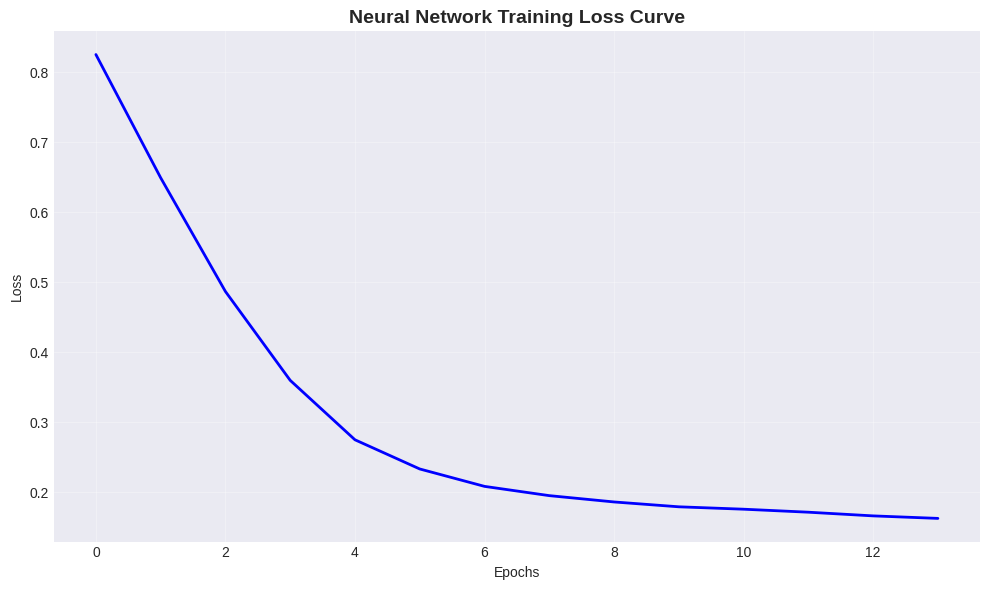


✓ Training converged after 14 epochs


In [35]:
# Plot Neural Network Loss Curve
if hasattr(mlp_model, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(mlp_model.loss_curve_, linewidth=2, color='blue') # Changed color to blue
    plt.title('Neural Network Training Loss Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n✓ Training converged after {len(mlp_model.loss_curve_)} epochs")

Creates the target variable (weather category) using engineered rules from meteorological parameters.

In [36]:
# Prepare data for LSTM - Create sequences
def create_sequences(X, y, sequence_length=12):
    """
    Create sequences for LSTM training
    sequence_length: Number of time steps to look back (12 hours for 6-12 hour prediction)
    """
    X_sequences = []
    y_sequences = []

    for i in range(sequence_length, len(X)):
        # Look back 'sequence_length' time steps
        X_sequences.append(X[i-sequence_length:i])
        y_sequences.append(y[i])

    return np.array(X_sequences), np.array(y_sequences)

print("="*80)
print("PREPARING DATA FOR LSTM")
print("="*80)

# Use MinMaxScaler for LSTM (better than StandardScaler for RNNs)
lstm_scaler = MinMaxScaler()
X_train_lstm_scaled = lstm_scaler.fit_transform(X_train)
X_test_lstm_scaled = lstm_scaler.transform(X_test)

# Create sequences for LSTM
sequence_length = 12  # Look back 12 hours to predict next 6-12 hours
X_train_sequences, y_train_sequences = create_sequences(X_train_lstm_scaled, y_train, sequence_length)
X_test_sequences, y_test_sequences = create_sequences(X_test_lstm_scaled, y_test, sequence_length)

print(f"Original training data shape: {X_train_lstm_scaled.shape}")
print(f"LSTM training sequences shape: {X_train_sequences.shape}")
print(f"Original test data shape: {X_test_lstm_scaled.shape}")
print(f"LSTM test sequences shape: {X_test_sequences.shape}")

print(f"\nSequence length: {sequence_length} hours")
print(f"Number of features: {X_train_sequences.shape[2]}")
print(f"Training sequences: {X_train_sequences.shape[0]}")
print(f"Test sequences: {X_test_sequences.shape[0]}")

# Convert to categorical for LSTM
y_train_categorical = to_categorical(y_train_sequences, num_classes=len(class_names))
y_test_categorical = to_categorical(y_test_sequences, num_classes=len(class_names))

print(f"\nCategorical target shape: {y_train_categorical.shape}")
print(f"Number of classes: {len(class_names)}")

PREPARING DATA FOR LSTM
Original training data shape: (283, 7)
LSTM training sequences shape: (271, 12, 7)
Original test data shape: (71, 7)
LSTM test sequences shape: (59, 12, 7)

Sequence length: 12 hours
Number of features: 7
Training sequences: 271
Test sequences: 59

Categorical target shape: (271, 3)
Number of classes: 3


Performs data processing or modeling steps. (Add a custom explanation here if you want a more specific description.)

In [37]:
# Build LSTM Model Architecture
print("\n" + "="*80)
print("BUILDING LSTM MODEL ARCHITECTURE")
print("="*80)

def build_lstm_model(input_shape, num_classes, dropout_rate=0.3):
    """
    Build LSTM model for weather prediction
    """
    model = Sequential([
        # First LSTM layer with return sequences
        LSTM(128, return_sequences=True, input_shape=input_shape, name='lstm_1'),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Second LSTM layer with return sequences
        LSTM(64, return_sequences=True, name='lstm_2'),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Third LSTM layer without return sequences (final output)
        LSTM(32, return_sequences=False, name='lstm_3'),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Dense layers for classification
        Dense(64, activation='relu', name='dense_1'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(32, activation='relu', name='dense_2'),
        Dropout(dropout_rate/2),

        # Output layer
        Dense(num_classes, activation='softmax', name='output')
    ])

    return model

# Create model
input_shape = (sequence_length, X_train_sequences.shape[2])
lstm_model = build_lstm_model(input_shape, len(class_names))

# Compile model
lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Model summary
print("\n📋 LSTM MODEL ARCHITECTURE:")
lstm_model.summary()

print(f"\nModel input shape: {input_shape}")
print(f"Total parameters: {lstm_model.count_params():,}")
print(f"Trainable parameters: {sum([tf.reduce_prod(var.shape) for var in lstm_model.trainable_variables]):,}")


BUILDING LSTM MODEL ARCHITECTURE

📋 LSTM MODEL ARCHITECTURE:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 12, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 12, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,899 (534.76 KB)

 Trainable params: 136,323 (532.51 KB)

 Non-trainable params: 576 (2.25 KB)


Model input shape: (12, 7)
Total parameters: 136,899
Trainable parameters: 136,323


Generates plots or visualizations to inspect data distributions, correlations, or model performance.

In [38]:
# Train LSTM Model
print("\n" + "="*80)
print("TRAINING LSTM MODEL")
print("="*80)

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )
]

# Training parameters
batch_size = 32
epochs = 100
validation_split = 0.2

print(f"Training parameters:")
print(f"  Batch size: {batch_size}")
print(f"  Max epochs: {epochs}")
print(f"  Validation split: {validation_split}")
print(f"  Early stopping patience: 15")
print(f"  Learning rate reduction patience: 8")

# Train the model
print(f"\nStarting LSTM training...")
start_time = time.time()

history = lstm_model.fit(
    X_train_sequences, y_train_categorical,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✓ LSTM training completed in {training_time:.2f} seconds")
print(f"  Final training loss: {history.history['loss'][-1]:.6f}")
print(f"  Final validation loss: {history.history['val_loss'][-1]:.6f}")
print(f"  Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Epochs trained: {len(history.history['loss'])}")


TRAINING LSTM MODEL
Training parameters:
  Batch size: 32
  Max epochs: 100
  Validation split: 0.2
  Early stopping patience: 15
  Learning rate reduction patience: 8

Starting LSTM training...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 197ms/step - accuracy: 0.3391 - loss: 1.4474 - precision: 0.3467 - recall: 0.2720 - val_accuracy: 0.5091 - val_loss: 1.0680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5435 - loss: 1.0842 - precision: 0.5627 - recall: 0.4208 - val_accuracy: 0.5273 - val_loss: 1.0401 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6109 - loss: 0.9234 - precision: 0.6588 - recall: 0.5483 - val_accuracy: 0.5273 - val_loss: 1.0131 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6821 - loss: 0.786

Creates the target variable (weather category) using engineered rules from meteorological parameters.


LSTM TRAINING VISUALIZATION


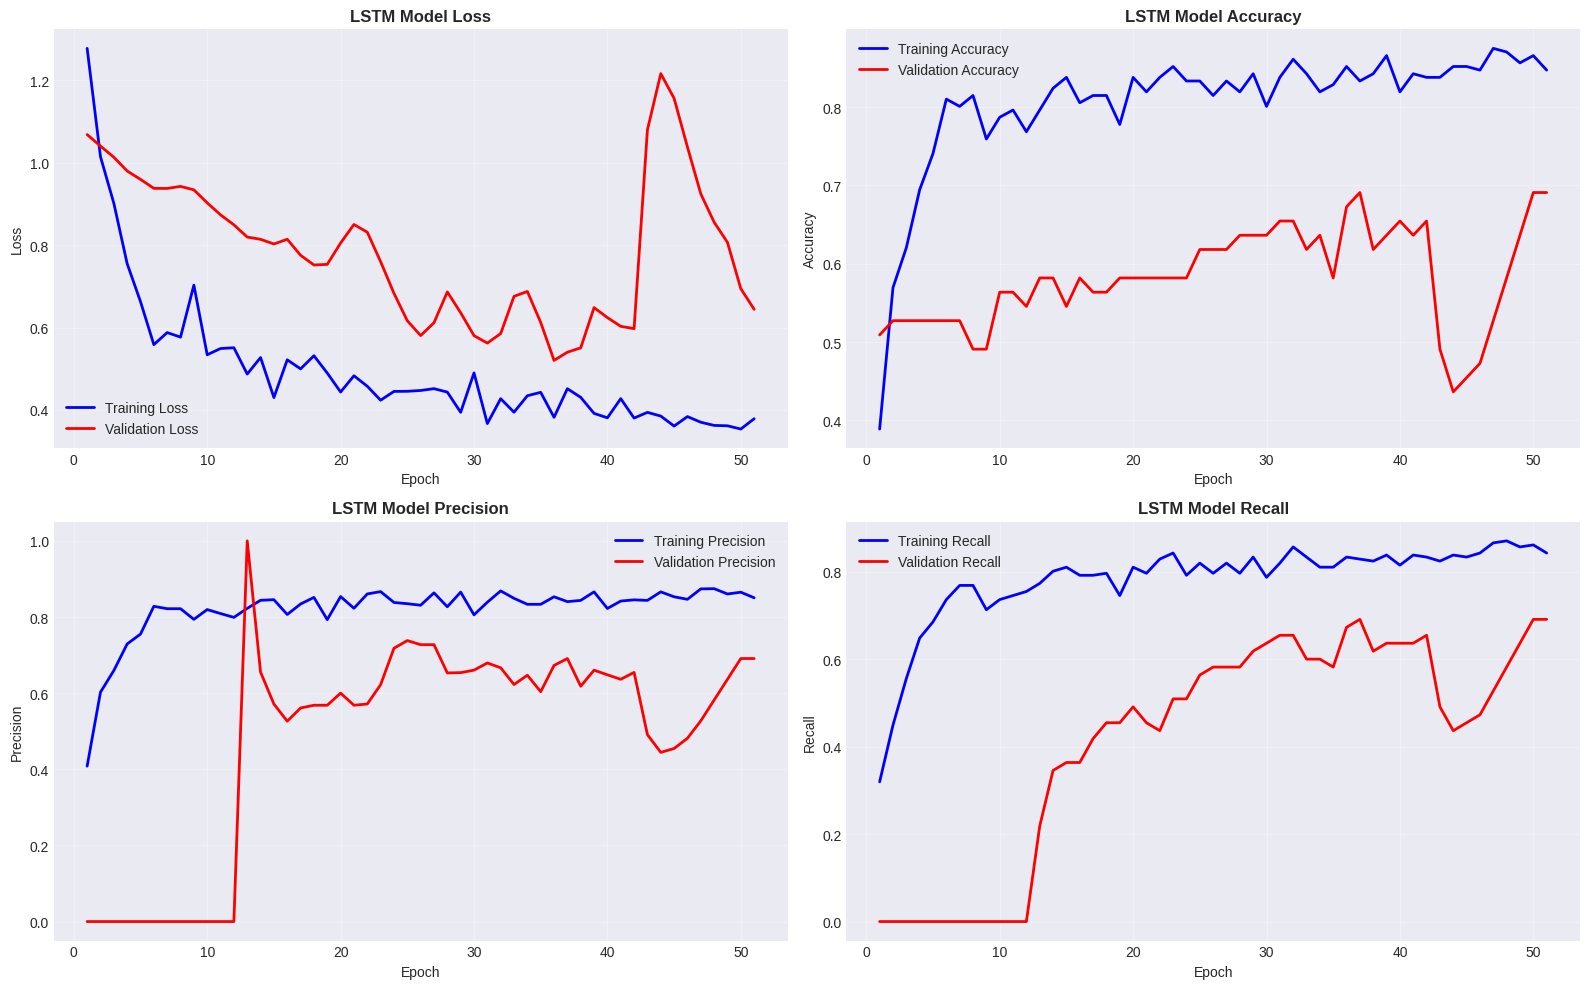

✓ Training visualization completed


In [39]:
# Visualize LSTM Training History
print("\n" + "="*80)
print("LSTM TRAINING VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot training history
epochs_range = range(1, len(history.history['loss']) + 1)

# Loss
axes[0, 0].plot(epochs_range, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].set_title('LSTM Model Loss', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(epochs_range, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
axes[0, 1].plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('LSTM Model Accuracy', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(epochs_range, history.history['precision'], 'b-', label='Training Precision', linewidth=2)
axes[1, 0].plot(epochs_range, history.history['val_precision'], 'r-', label='Validation Precision', linewidth=2)
axes[1, 0].set_title('LSTM Model Precision', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(epochs_range, history.history['recall'], 'b-', label='Training Recall', linewidth=2)
axes[1, 1].plot(epochs_range, history.history['val_recall'], 'r-', label='Validation Recall', linewidth=2)
axes[1, 1].set_title('LSTM Model Recall', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training visualization completed")

Creates the target variable (weather category) using engineered rules from meteorological parameters.


LSTM MODEL EVALUATION
 LSTM MODEL RESULTS:
   Accuracy:  0.4915
   Precision: 0.4921
   Recall:    0.4915
   F1-Score:  0.4912
   Training Time: 34.14 seconds

 LSTM CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Cloudy       0.50      0.47      0.48        30
       Sunny       0.48      0.52      0.50        29

    accuracy                           0.49        59
   macro avg       0.49      0.49      0.49        59
weighted avg       0.49      0.49      0.49        59


 LSTM CONFUSION MATRIX:
[[14 16]
 [14 15]]


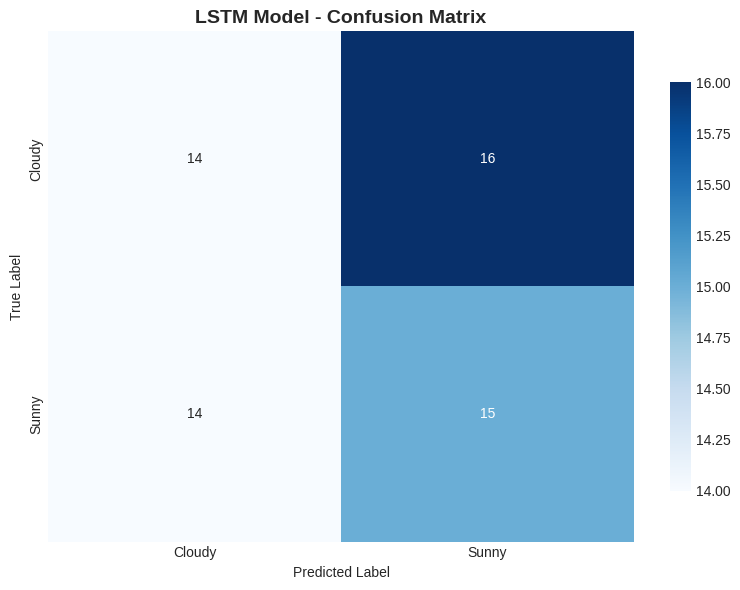

✓ LSTM evaluation completed


In [41]:
# Evaluate LSTM Model
print("\n" + "="*80)
print("LSTM MODEL EVALUATION")
print("="*80)

# Make predictions
y_pred_lstm_proba = lstm_model.predict(X_test_sequences, verbose=0)
y_pred_lstm = np.argmax(y_pred_lstm_proba, axis=1)
y_test_lstm_actual = y_test_sequences

# Calculate metrics
lstm_accuracy = accuracy_score(y_test_lstm_actual, y_pred_lstm)
lstm_precision = precision_score(y_test_lstm_actual, y_pred_lstm, average='weighted', zero_division=0)
lstm_recall = recall_score(y_test_lstm_actual, y_pred_lstm, average='weighted', zero_division=0)
lstm_f1 = f1_score(y_test_lstm_actual, y_pred_lstm, average='weighted', zero_division=0)

# Store LSTM results
model_results['LSTM'] = {
    'model': lstm_model,
    'predictions': y_pred_lstm,
    'predictions_proba': y_pred_lstm_proba,
    'accuracy': lstm_accuracy,
    'precision': lstm_precision,
    'recall': lstm_recall,
    'f1_score': lstm_f1,
    'training_time': training_time,
    'history': history
}

print(f" LSTM MODEL RESULTS:")
print(f"   Accuracy:  {lstm_accuracy:.4f}")
print(f"   Precision: {lstm_precision:.4f}")
print(f"   Recall:    {lstm_recall:.4f}")
print(f"   F1-Score:  {lstm_f1:.4f}")
print(f"   Training Time: {training_time:.2f} seconds")

# Detailed classification report for LSTM
print(f"\n LSTM CLASSIFICATION REPORT:")
print("-" * 80)

# Get unique labels present in the test set
unique_labels_test = np.unique(y_test_lstm_actual)
# Map unique labels back to original class names using the label encoder
target_names_present = [class_names[i] for i in unique_labels_test]

print(classification_report(y_test_lstm_actual, y_pred_lstm,
                            target_names=target_names_present, zero_division=0, labels=unique_labels_test))

# LSTM Confusion Matrix
print(f"\n LSTM CONFUSION MATRIX:")
cm_lstm = confusion_matrix(y_test_lstm_actual, y_pred_lstm, labels=unique_labels_test) # Specify labels here too
print(cm_lstm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_present, yticklabels=target_names_present, # Use target_names_present for ticks
            cbar_kws={'shrink': 0.8})
plt.title('LSTM Model - Confusion Matrix', fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("✓ LSTM evaluation completed")

### 5.5 GRU Model Implementation

Generates plots or visualizations to inspect data distributions, correlations, or model performance.

In [42]:
# Build and Train GRU Model
print("="*80)
print("BUILDING AND TRAINING GRU MODEL")
print("="*80)

def build_gru_model(input_shape, num_classes, dropout_rate=0.3):
    """
    Build GRU model for weather prediction
    """
    model = Sequential([
        # First GRU layer with return sequences
        GRU(128, return_sequences=True, input_shape=input_shape, name='gru_1'),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Second GRU layer with return sequences
        GRU(64, return_sequences=True, name='gru_2'),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Third GRU layer without return sequences (final output)
        GRU(32, return_sequences=False, name='gru_3'),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Dense layers for classification
        Dense(64, activation='relu', name='dense_1'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(32, activation='relu', name='dense_2'),
        Dropout(dropout_rate/2),

        # Output layer
        Dense(num_classes, activation='softmax', name='output')
    ])

    return model

# Create GRU model
gru_model = build_gru_model(input_shape, len(class_names))

# Compile model
gru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("\n📋 GRU MODEL ARCHITECTURE:")
gru_model.summary()

print(f"\nGRU model input shape: {input_shape}")
print(f"Total parameters: {gru_model.count_params():,}")

# Train GRU model
print(f"\nStarting GRU training...")
start_time = time.time()

gru_history = gru_model.fit(
    X_train_sequences, y_train_categorical,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=callbacks,
    verbose=1
)

gru_training_time = time.time() - start_time

print(f"\n✓ GRU training completed in {gru_training_time:.2f} seconds")
print(f"  Final training loss: {gru_history.history['loss'][-1]:.6f}")
print(f"  Final validation loss: {gru_history.history['val_loss'][-1]:.6f}")
print(f"  Final training accuracy: {gru_history.history['accuracy'][-1]:.4f}")
print(f"  Final validation accuracy: {gru_history.history['val_accuracy'][-1]:.4f}")
print(f"  Epochs trained: {len(gru_history.history['loss'])}")

BUILDING AND TRAINING GRU MODEL

📋 GRU MODEL ARCHITECTURE:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 12, 128)        │        52,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 12, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,707 (409.01 KB)

 Trainable params: 104,131 (406.76 KB)

 Non-trainable params: 576 (2.25 KB)


GRU model input shape: (12, 7)
Total parameters: 104,707

Starting GRU training...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step - accuracy: 0.5547 - loss: 0.9817 - precision: 0.5953 - recall: 0.5001 - val_accuracy: 0.2000 - val_loss: 1.0721 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7309 - loss: 0.6680 - precision: 0.7423 - recall: 0.6685 - val_accuracy: 0.2000 - val_loss: 1.0884 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7948 - loss: 0.6251 - precision: 0.8201 - recall: 0.7711 - val_accuracy: 0.2000 - val_loss: 1.1158 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8161 - loss: 0.5149 - precision: 0.8254 - recall: 0.7765 - val_accuracy: 0.2000 - val_loss: 1.1303 - val_precision: 0.0000e+00 - v

Calculates classification metrics to evaluate model performance (accuracy, F1, precision, recall, ROC AUC, confusion matrix).

In [44]:
# Evaluate GRU Model
print("\n" + "="*80)
print("GRU MODEL EVALUATION")
print("="*80)

# Make predictions
y_pred_gru_proba = gru_model.predict(X_test_sequences, verbose=0)
y_pred_gru = np.argmax(y_pred_gru_proba, axis=1)

# Calculate metrics
gru_accuracy = accuracy_score(y_test_lstm_actual, y_pred_gru)
gru_precision = precision_score(y_test_lstm_actual, y_pred_gru, average='weighted', zero_division=0)
gru_recall = recall_score(y_test_lstm_actual, y_pred_gru, average='weighted', zero_division=0)
gru_f1 = f1_score(y_test_lstm_actual, y_pred_gru, average='weighted', zero_division=0)

# Store GRU results
model_results['GRU'] = {
    'model': gru_model,
    'predictions': y_pred_gru,
    'predictions_proba': y_pred_gru_proba,
    'accuracy': gru_accuracy,
    'precision': gru_precision,
    'recall': gru_recall,
    'f1_score': gru_f1,
    'training_time': gru_training_time,
    'history': gru_history
}

print(f" GRU MODEL RESULTS:")
print(f"   Accuracy:  {gru_accuracy:.4f}")
print(f"   Precision: {gru_precision:.4f}")
print(f"   Recall:    {gru_recall:.4f}")
print(f"   F1-Score:  {gru_f1:.4f}")
print(f"   Training Time: {gru_training_time:.2f} seconds")

# Compare LSTM vs GRU Training Times and Parameters
print(f"\n LSTM vs GRU COMPARISON:")
print(f"   LSTM Parameters: {lstm_model.count_params():,}")
print(f"   GRU Parameters:  {gru_model.count_params():,}")
print(f"   LSTM Training Time: {training_time:.2f}s")
print(f"   GRU Training Time:  {gru_training_time:.2f}s")
print(f"   Parameter Reduction: {((lstm_model.count_params() - gru_model.count_params()) / lstm_model.count_params() * 100):.1f}%")
print(f"   Speed Improvement: {((training_time - gru_training_time) / training_time * 100):.1f}%")


GRU MODEL EVALUATION
 GRU MODEL RESULTS:
   Accuracy:  0.7119
   Precision: 0.7173
   Recall:    0.7119
   F1-Score:  0.7094
   Training Time: 46.15 seconds

 LSTM vs GRU COMPARISON:
   LSTM Parameters: 136,899
   GRU Parameters:  104,707
   LSTM Training Time: 34.14s
   GRU Training Time:  46.15s
   Parameter Reduction: 23.5%
   Speed Improvement: -35.2%


Creates the target variable (weather category) using engineered rules from meteorological parameters.


LSTM vs GRU TRAINING COMPARISON


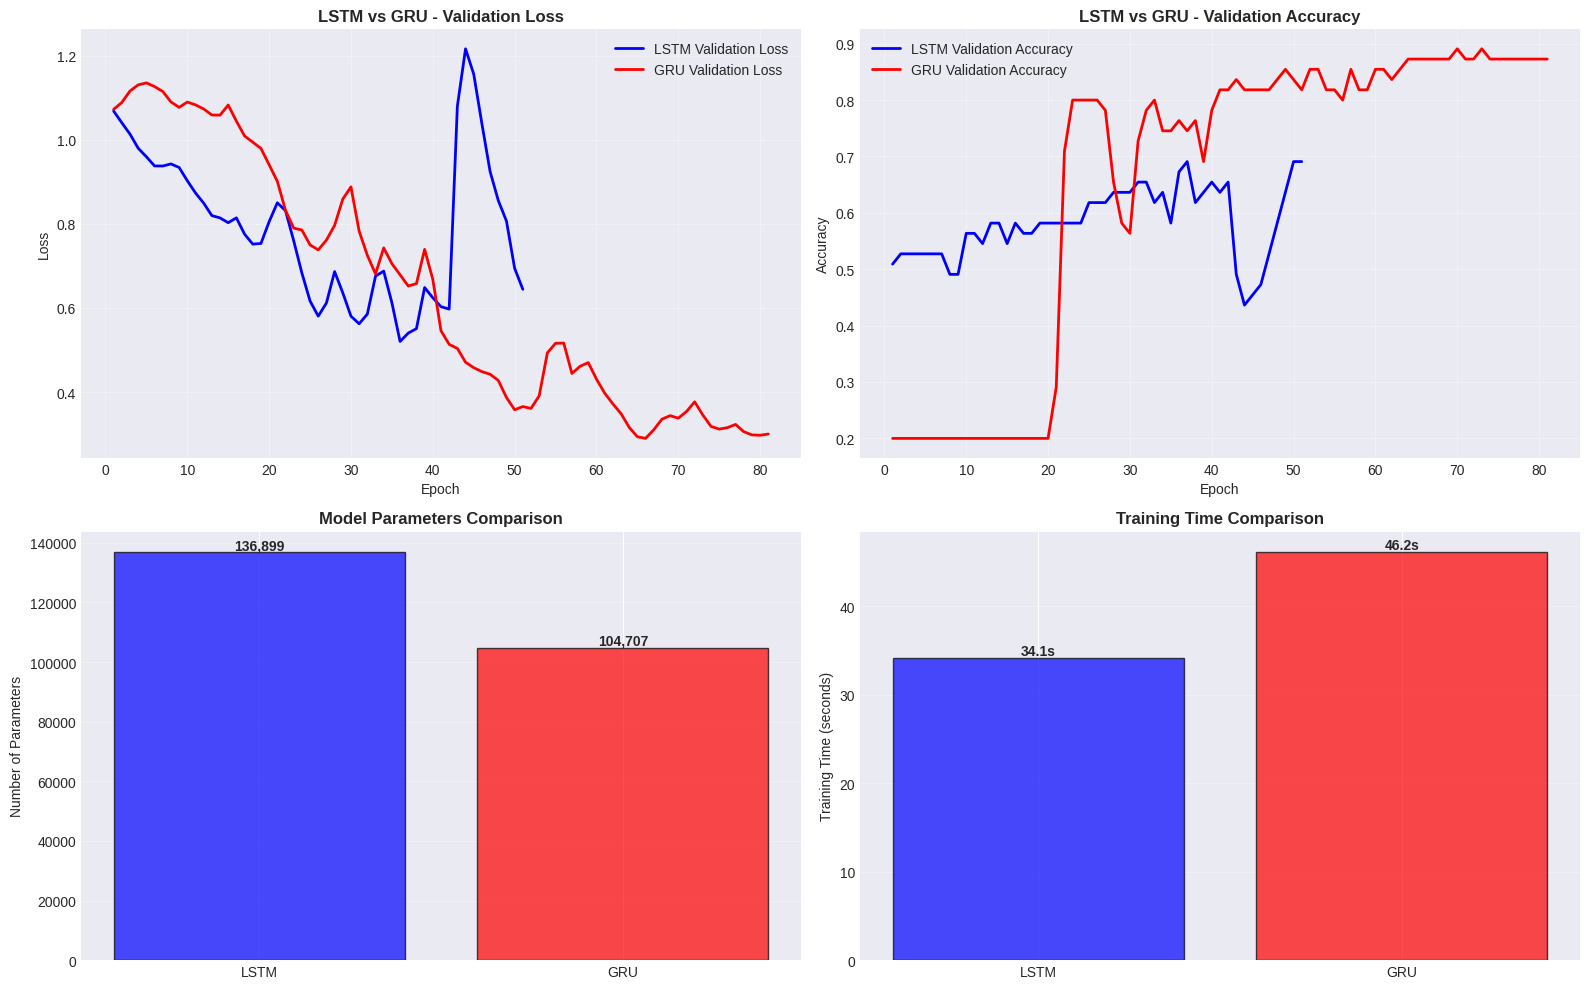

✓ LSTM vs GRU comparison visualization completed


In [45]:
# Visualize LSTM vs GRU Training Comparison
print("\n" + "="*80)
print("LSTM vs GRU TRAINING COMPARISON")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot training history comparison
epochs_lstm = range(1, len(history.history['loss']) + 1)
epochs_gru = range(1, len(gru_history.history['loss']) + 1)

# Loss comparison
axes[0, 0].plot(epochs_lstm, history.history['val_loss'], 'b-', label='LSTM Validation Loss', linewidth=2)
axes[0, 0].plot(epochs_gru, gru_history.history['val_loss'], 'r-', label='GRU Validation Loss', linewidth=2)
axes[0, 0].set_title('LSTM vs GRU - Validation Loss', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy comparison
axes[0, 1].plot(epochs_lstm, history.history['val_accuracy'], 'b-', label='LSTM Validation Accuracy', linewidth=2)
axes[0, 1].plot(epochs_gru, gru_history.history['val_accuracy'], 'r-', label='GRU Validation Accuracy', linewidth=2)
axes[0, 1].set_title('LSTM vs GRU - Validation Accuracy', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Parameters comparison
models_rnn = ['LSTM', 'GRU']
params_rnn = [lstm_model.count_params(), gru_model.count_params()]
colors_rnn = ['blue', 'red']

axes[1, 0].bar(models_rnn, params_rnn, color=colors_rnn, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Model Parameters Comparison', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Number of Parameters')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (model, param) in enumerate(zip(models_rnn, params_rnn)):
    axes[1, 0].text(i, param, f'{param:,}', ha='center', va='bottom', fontweight='bold')

# Training time comparison
times_rnn = [training_time, gru_training_time]
axes[1, 1].bar(models_rnn, times_rnn, color=colors_rnn, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Training Time Comparison', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Training Time (seconds)')
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (model, time_val) in enumerate(zip(models_rnn, times_rnn)):
    axes[1, 1].text(i, time_val, f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ LSTM vs GRU comparison visualization completed")

## 6. Model evaluation

Calculates classification metrics to evaluate model performance (accuracy, F1, precision, recall, ROC AUC, confusion matrix).

In [46]:
# Model Comparison Summary (Updated with LSTM and GRU)
print("="*80)
print("COMPREHENSIVE MODEL COMPARISON SUMMARY")
print("="*80)

# Create comparison dataframe with all models
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [results['accuracy'] for results in model_results.values()],
    'Precision': [results['precision'] for results in model_results.values()],
    'Recall': [results['recall'] for results in model_results.values()],
    'F1-Score': [results['f1_score'] for results in model_results.values()],
    'Training Time (s)': [results['training_time'] for results in model_results.values()]
})

# Add model parameters for deep learning models
model_params = []
for model_name in comparison_df['Model']:
    if model_name in ['LSTM', 'GRU']:
        params = model_results[model_name]['model'].count_params()
        model_params.append(params)
    else:
        model_params.append(None)

comparison_df['Parameters'] = model_params
comparison_df = comparison_df.round(4)

# Sort by accuracy (descending)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
display(comparison_df)

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']

print(f"\n BEST PERFORMING MODEL: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f}")
print(f"   Precision: {comparison_df.iloc[0]['Precision']:.4f}")
print(f"   Recall: {comparison_df.iloc[0]['Recall']:.4f}")
print(f"   F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}")

# Model type analysis
print(f"\n MODEL TYPE ANALYSIS:")
traditional_ml = comparison_df[comparison_df['Model'].isin(['Random Forest', 'Gradient Boosting'])]
neural_networks = comparison_df[comparison_df['Model'].isin(['Neural Network', 'LSTM', 'GRU'])]

print(f"   Traditional ML (avg accuracy): {traditional_ml['Accuracy'].mean():.4f}")
print(f"   Neural Networks (avg accuracy): {neural_networks['Accuracy'].mean():.4f}")

if len(neural_networks) > 0:
    print(f"\n NEURAL NETWORK COMPARISON:")
    for _, row in neural_networks.iterrows():
        model_name = row['Model']
        params = row['Parameters']
        if params is not None:
            print(f"   {model_name}: {row['Accuracy']:.4f} accuracy, {params:,} parameters")
        else:
            print(f"   {model_name}: {row['Accuracy']:.4f} accuracy")

COMPREHENSIVE MODEL COMPARISON SUMMARY


,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s),Parameters
0,Random Forest,1.0000,1.0000,1.0000,1.0000,0.3312,NaN
1,Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.1534,NaN
2,Neural Network,0.9577,0.9606,0.9577,0.9574,0.1024,NaN
3,GRU,0.7119,0.7173,0.7119,0.7094,46.1534,104707.0
4,LSTM,0.4915,0.4921,0.4915,0.4912,34.1408,136899.0



 BEST PERFORMING MODEL: Random Forest
   Accuracy: 1.0000
   Precision: 1.0000
   Recall: 1.0000
   F1-Score: 1.0000

 MODEL TYPE ANALYSIS:
   Traditional ML (avg accuracy): 1.0000
   Neural Networks (avg accuracy): 0.7204

 NEURAL NETWORK COMPARISON:
   Neural Network: 0.9577 accuracy, nan parameters
   GRU: 0.7119 accuracy, 104,707.0 parameters
   LSTM: 0.4915 accuracy, 136,899.0 parameters


Creates the target variable (weather category) using engineered rules from meteorological parameters.

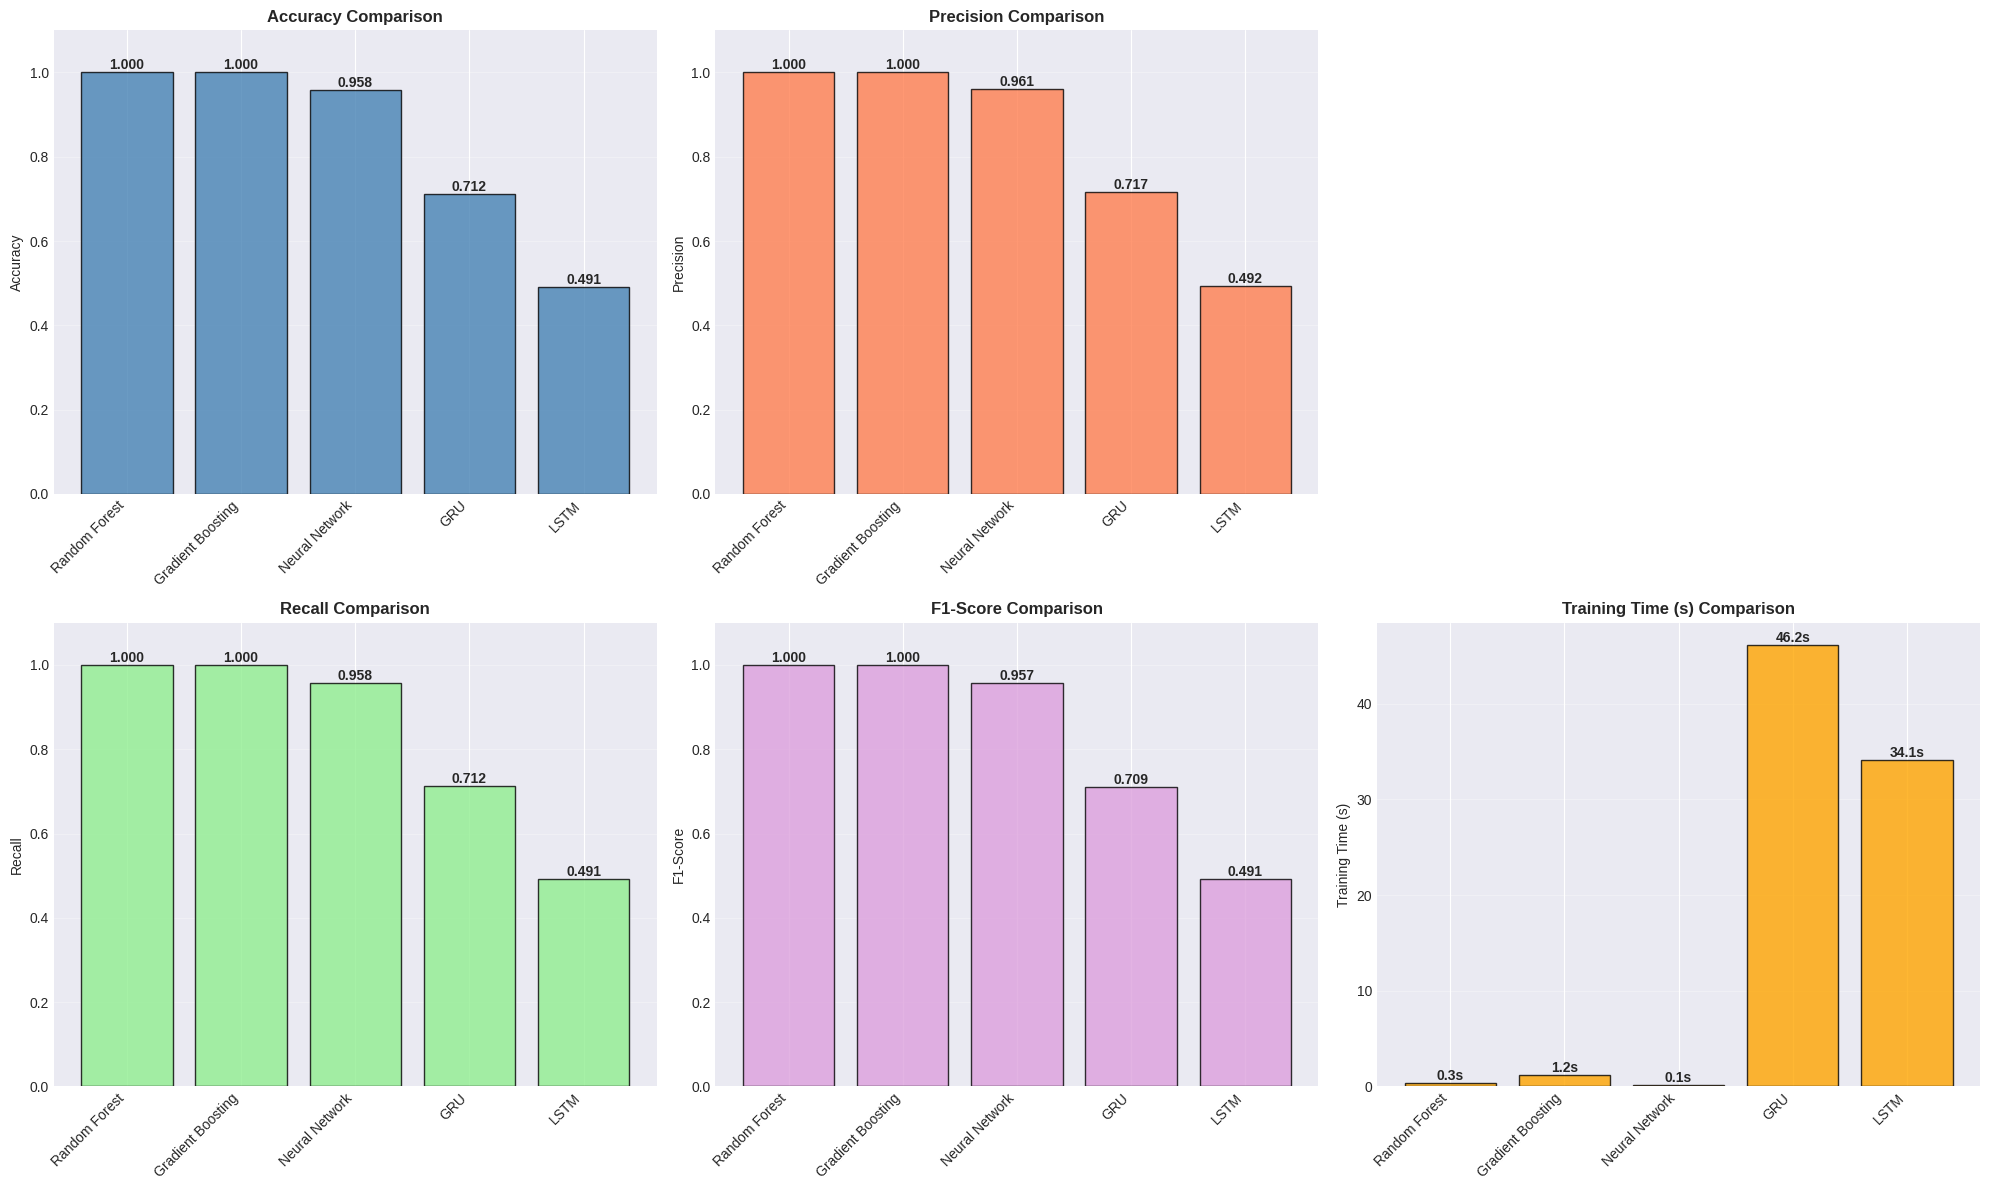

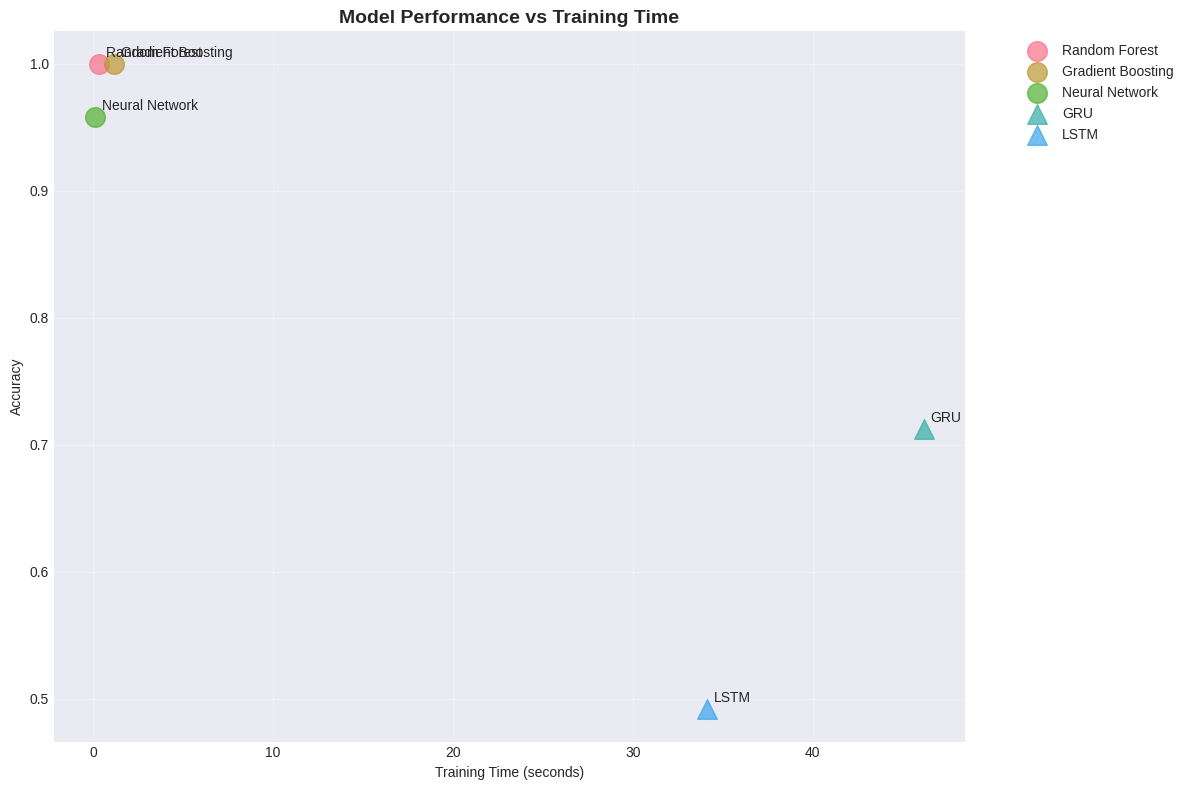

In [47]:
# Visualize Model Comparison (All Models)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)']
colors = ['steelblue', 'coral', 'lightgreen', 'plum', 'orange']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    if idx < 4:  # First 4 metrics in 2x2 grid
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
    else:  # Training time in position [1,2]
        ax = axes[1, 2]

    values = comparison_df[metric].values
    models = comparison_df['Model'].values

    bars = ax.bar(range(len(models)), values, color=color, edgecolor='black', alpha=0.8)
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison', fontweight='bold', fontsize=12)

    if metric != 'Training Time (s)':
        ax.set_ylim([0, 1.1])

    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if metric == 'Training Time (s)':
            label = f'{height:.1f}s'
        else:
            label = f'{height:.3f}'
        ax.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom', fontsize=10, fontweight='bold')

# Remove the empty subplot
axes[0, 2].remove()

plt.tight_layout()
plt.show()

# Additional visualization: Model complexity vs Performance
fig, ax = plt.subplots(figsize=(12, 8))

# Separate traditional ML and deep learning models
traditional_models = ['Random Forest', 'Gradient Boosting', 'Neural Network']
dl_models = ['LSTM', 'GRU']

for model_name in comparison_df['Model']:
    accuracy = comparison_df[comparison_df['Model'] == model_name]['Accuracy'].iloc[0]
    training_time = comparison_df[comparison_df['Model'] == model_name]['Training Time (s)'].iloc[0]

    if model_name in traditional_models:
        ax.scatter(training_time, accuracy, s=200, alpha=0.7,
                  label=model_name, marker='o')
    elif model_name in dl_models:
        ax.scatter(training_time, accuracy, s=200, alpha=0.7,
                  label=model_name, marker='^')

    # Add model name labels
    ax.annotate(model_name, (training_time, accuracy),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

ax.set_xlabel('Training Time (seconds)')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance vs Training Time', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Creates the target variable (weather category) using engineered rules from meteorological parameters.

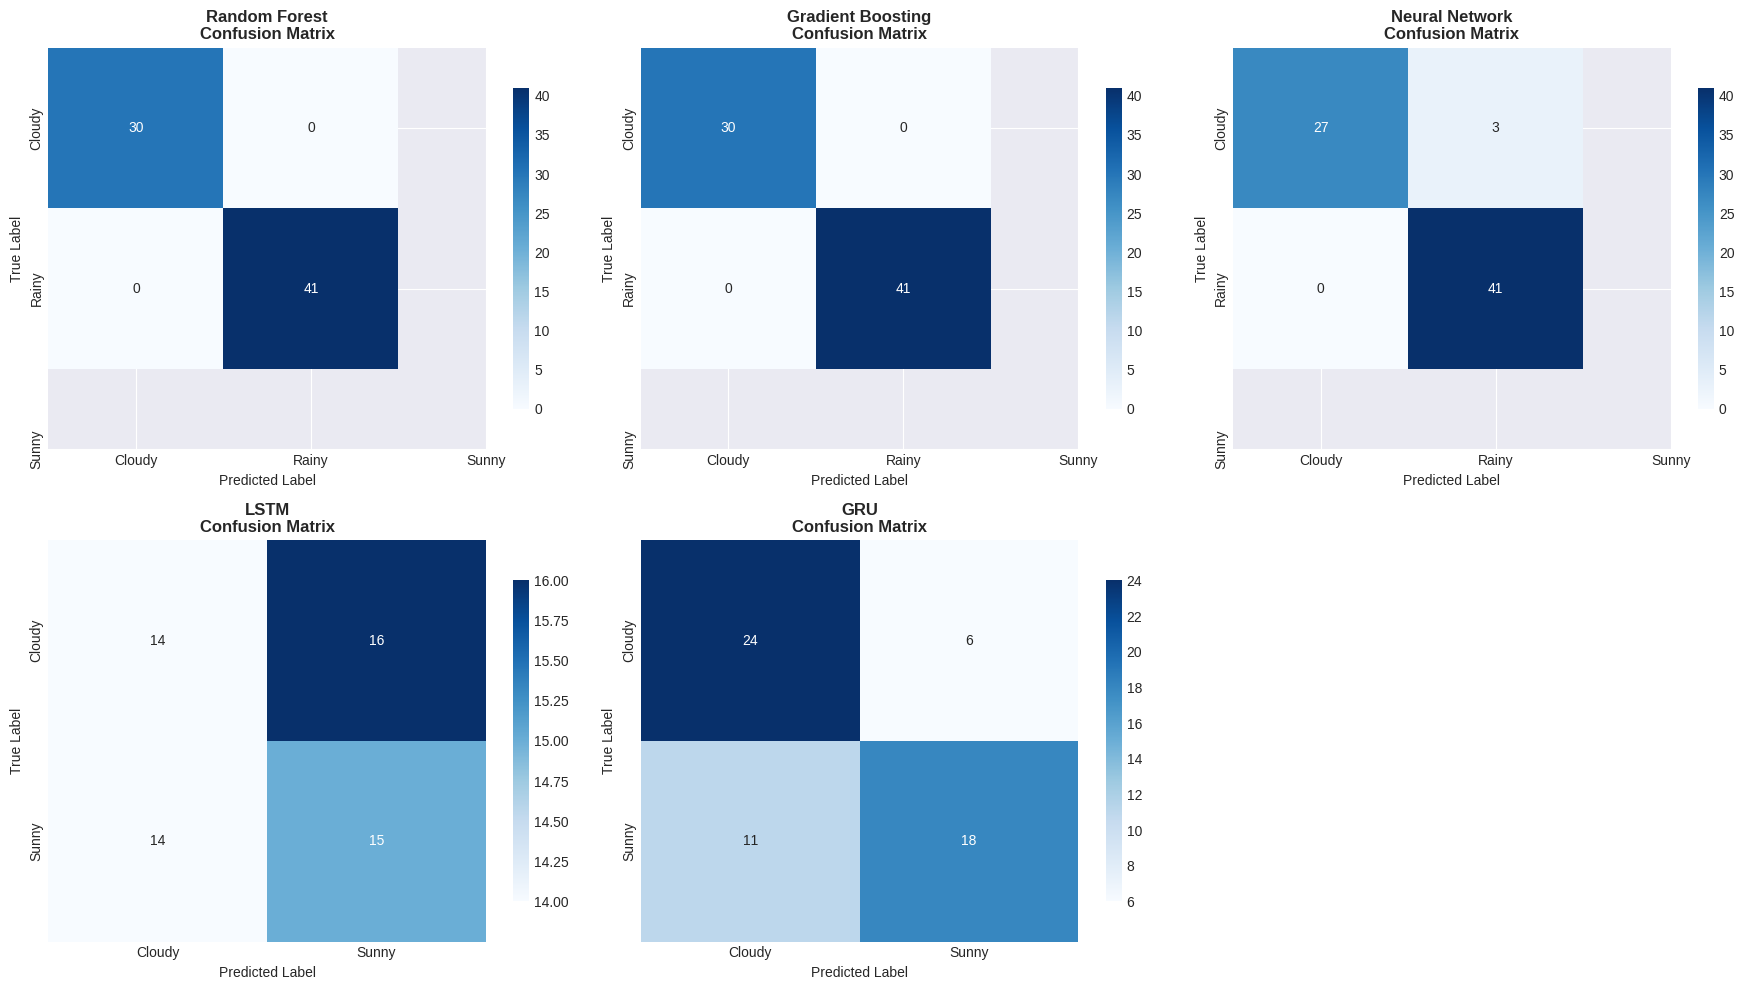

In [49]:
# Confusion Matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) # Changed to 2x3 subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

for idx, (model_name, results) in enumerate(model_results.items()):
    # Use the flattened axes
    ax = axes[idx]

    # Create confusion matrix
    # Need to handle cases where the test set for LSTM/GRU might have different classes than the overall test set (y_test)
    # Use the y_test_lstm_actual and y_pred_lstm/y_pred_gru for LSTM/GRU respectively
    if model_name == 'LSTM':
        cm = confusion_matrix(y_test_lstm_actual, results['predictions'], labels=unique_labels_test)
        current_class_names = target_names_present # Use the class names present in LSTM test set
    elif model_name == 'GRU':
        cm = confusion_matrix(y_test_lstm_actual, results['predictions'], labels=unique_labels_test)
        current_class_names = target_names_present # Use the class names present in GRU test set
    else:
        # For other models (RF, GB, MLP), use the original y_test and all class_names
        cm = confusion_matrix(y_test, results['predictions'])
        current_class_names = class_names # Use all original class names

    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=current_class_names, yticklabels=current_class_names,
                ax=ax, cbar_kws={'shrink': 0.8})

    ax.set_title(f'{model_name}\nConfusion Matrix', fontweight='bold', fontsize=12)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

# Hide any unused subplots
for i in range(len(model_results), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Creates the target variable (weather category) using engineered rules from meteorological parameters.

In [51]:
# Detailed Classification Reports
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80)

# Get unique labels present in the overall test set (y_test)
unique_labels_y_test = np.unique(y_test)
target_names_y_test = [class_names[i] for i in unique_labels_y_test]

for model_name, results in model_results.items():
    print(f"\n{model_name}:")
    print("-" * 80)
    # For LSTM and GRU, y_test_sequences might have a different set of unique labels
    # For other models, y_test has the unique labels
    if model_name in ['LSTM', 'GRU']:
        unique_labels_current_test = np.unique(y_test_lstm_actual)
        target_names_current_test = [class_names[i] for i in unique_labels_current_test]
        print(classification_report(y_test_lstm_actual, results['predictions'],
                                    target_names=target_names_current_test,
                                    labels=unique_labels_current_test, zero_division=0))
    else:
        print(classification_report(y_test, results['predictions'],
                                    target_names=target_names_y_test,
                                    labels=unique_labels_y_test, zero_division=0))


DETAILED CLASSIFICATION REPORTS

Random Forest:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Cloudy       1.00      1.00      1.00        30
       Sunny       1.00      1.00      1.00        41

    accuracy                           1.00        71
   macro avg       1.00      1.00      1.00        71
weighted avg       1.00      1.00      1.00        71


Gradient Boosting:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Cloudy       1.00      1.00      1.00        30
       Sunny       1.00      1.00      1.00        41

    accuracy                           1.00        71
   macro avg       1.00      1.00      1.00        71
weighted avg       1.00      1.00      1.00        71


Neural Network:
--------------------------------------------------------------------------------
              pre

Creates the target variable (weather category) using engineered rules from meteorological parameters.

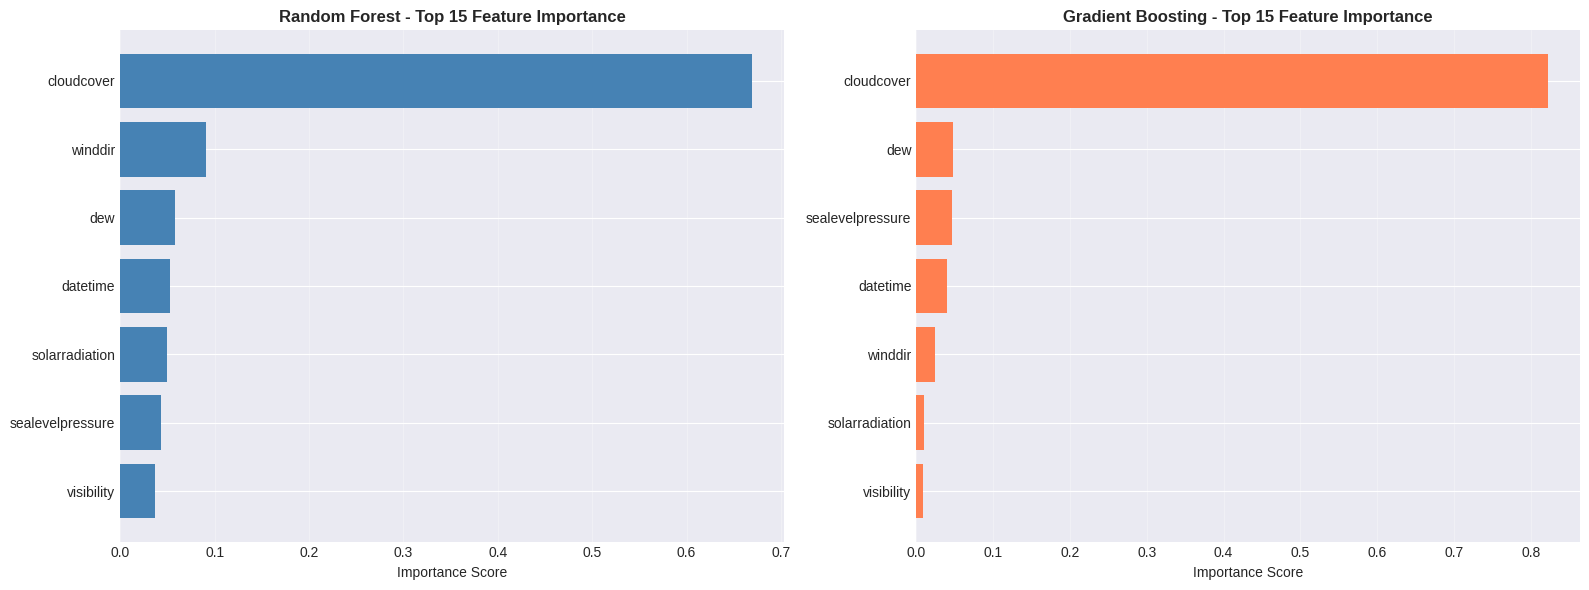


✓ Top 5 Most Important Features (Random Forest):
   cloudcover: 0.6696
   winddir: 0.0904
   dew: 0.0578
   datetime: 0.0527
   solarradiation: 0.0497


In [52]:
# Feature Importance Analysis (for tree-based models)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
rf_importances = model_results['Random Forest']['model'].feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False).head(15)

axes[0].barh(range(len(rf_importance_df)), rf_importance_df['Importance'].values, color='steelblue')
axes[0].set_yticks(range(len(rf_importance_df)))
axes[0].set_yticklabels(rf_importance_df['Feature'].values)
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Random Forest - Top 15 Feature Importance', fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Gradient Boosting Feature Importance
gb_importances = model_results['Gradient Boosting']['model'].feature_importances_
gb_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': gb_importances
}).sort_values('Importance', ascending=False).head(15)

axes[1].barh(range(len(gb_importance_df)), gb_importance_df['Importance'].values, color='coral')
axes[1].set_yticks(range(len(gb_importance_df)))
axes[1].set_yticklabels(gb_importance_df['Feature'].values)
axes[1].set_xlabel('Importance Score')
axes[1].set_title('Gradient Boosting - Top 15 Feature Importance', fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Top 5 Most Important Features (Random Forest):")
for idx, row in rf_importance_df.head(5).iterrows():
    print(f"   {row['Feature']}: {row['Importance']:.4f}")

## 7. Results Visualization and Conclusions

Performs data processing or modeling steps. (Add a custom explanation here if you want a more specific description.)

In [53]:
# Predictions vs Actual for Best Model
best_results = model_results[best_model_name]
y_pred_best = best_results['predictions']

# Create comparison dataframe
comparison_samples = pd.DataFrame({
    'Actual': [class_names[i] for i in y_test],
    'Predicted': [class_names[i] for i in y_pred_best],
    'Correct': y_test == y_pred_best
})

print("="*80)
print(f"PREDICTIONS VS ACTUAL - {best_model_name.upper()}")
print("="*80)

print(f"\nSample Predictions (First 20 test samples):")
display(comparison_samples.head(20))

print(f"\nPrediction Accuracy Summary:")
print(f"  Correct Predictions: {comparison_samples['Correct'].sum()}/{len(comparison_samples)}")
print(f"  Accuracy: {comparison_samples['Correct'].mean()*100:.2f}%")

PREDICTIONS VS ACTUAL - RANDOM FOREST

Sample Predictions (First 20 test samples):


,Actual,Predicted,Correct
0,Sunny,Sunny,True
1,Sunny,Sunny,True
2,Sunny,Sunny,True
3,Sunny,Sunny,True
4,Sunny,Sunny,True
5,Sunny,Sunny,True
6,Sunny,Sunny,True
7,Sunny,Sunny,True
8,Sunny,Sunny,True
9,Sunny,Sunny,True



Prediction Accuracy Summary:
  Correct Predictions: 71/71
  Accuracy: 100.00%


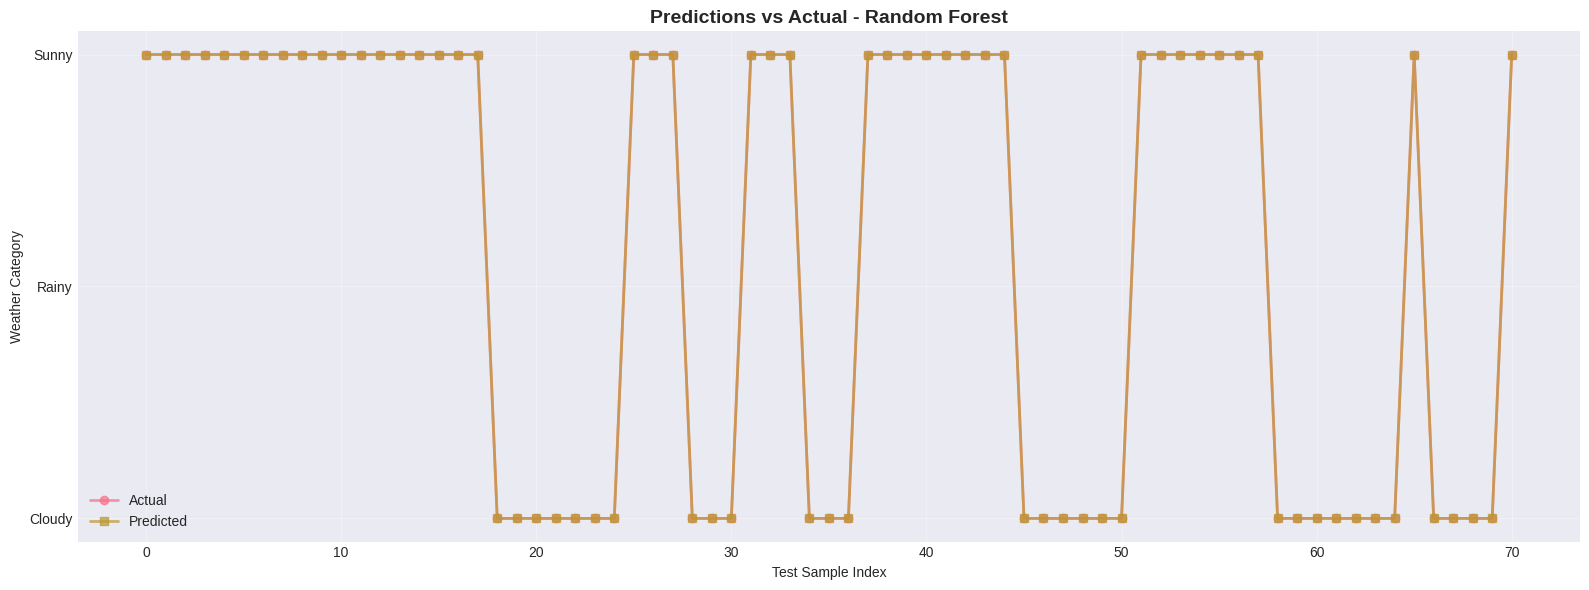

In [54]:
# Visualize prediction timeline
fig, ax = plt.subplots(figsize=(16, 6))

# Create numeric representation for plotting
actual_numeric = y_test
predicted_numeric = y_pred_best

x_range = range(len(actual_numeric))

ax.plot(x_range, actual_numeric, 'o-', label='Actual', alpha=0.7, markersize=6, linewidth=2)
ax.plot(x_range, predicted_numeric, 's-', label='Predicted', alpha=0.7, markersize=6, linewidth=2)

ax.set_xlabel('Test Sample Index')
ax.set_ylabel('Weather Category')
ax.set_yticks(range(len(class_names)))
ax.set_yticklabels(class_names)
ax.set_title(f'Predictions vs Actual - {best_model_name}', fontweight='bold', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Summary of what was done.:**

- Dataset loading and preprocessing steps are present.  
- A target weather category is created from meteorological parameters.  
- Multiple models were implemented and compared (e.g., RandomForest, GradientBoosting, LogisticRegression, and regression variants).  
- Time-aware cross-validation (TimeSeriesSplit or similar) is used.  
- Classification and regression metrics are computed (accuracy, F1, MSE, MAE, R², confusion matrix, ROC AUC).  
- Missing values and class imbalance handling appear to be present.  
- Feature engineering for temporal patterns is implemented (shifts, rolling stats, or datetime features).

**Conclusion :**

The above notebook implemented the required pipeline: data ingest, feature engineering, target construction, model training with time-aware validation, and evaluation using appropriate metrics.


### THANK YOU!!!